In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from cost_func import (unstable_percentage_model,
                       weaning_score_physician_gradient,
                       weaning_score_physician_merged,
                        weaning_score_model_merged,
                        unstable_percentage_model_merged,
                        compute_acp_cost,
                        aggregate_air_model,
                        weaning_score_model_gradient,
                        weaning_score_model,
                        compute_acp_cost_model,
                        unstable_percentage_model_gradient,
                        compute_map_physician_air, 
                        is_stable,
                        compute_hr_physician_air,
                        compute_pulsatility_physician_air, 
                        unstable_percentage, 
                        aggregate_air_physician,
                        weaning_score_physician,
                        super_metric
)
from reward_func import compute_reward_smooth
from model import WorldModel
from rl_env import AbiomedRLEnvFactory
from cost_func import overall_acp_cost

DATA_PATH = "/abiomed/downsampled/10min_1hr_all_data.pkl"
#this is just for the visualization so it isn't messy
MAX_STEPS_TO_PLOT = 2000

In [3]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)
episodes = np.concatenate((data['train'],data['val'], data['test']), axis=0)
# episodes = data['train']
print(f"Keys in dataset: {list(data.keys())}")
print(f"Shape of combined set: {len(episodes)}")

Keys in dataset: ['train', 'val', 'test', 'mean', 'std']
Shape of combined set: 17865


In [4]:
#to numpy if tensor
if isinstance(episodes, torch.Tensor):    
    episodes_np = episodes.numpy()  
else:
    episodes_np = np.array(episodes)
actions_all = episodes_np[:, :, -1]

In [5]:
def plot_hist(acp_list, ws_list, rwd_list, title):
    col_w_in   = 3.25   # one-column width (IEEE ~3.45", NeurIPS 3.25")
    row_h_in   = 1.8    # height per subplot (increase to make each panel taller)
    v_gap_in   = 0.8   # vertical gap between rows (inches)

    fig_h_in = 3 * row_h_in + 2 * v_gap_in

    fig, axes = plt.subplots(
        nrows=3, ncols=1,
        figsize=(col_w_in, fig_h_in),
        dpi=300,
        constrained_layout=False
    )
    # Control margins + gaps explicitly
    fig.subplots_adjust(left=0.18, right=0.98, top=0.88, bottom=0.12,
                        hspace=v_gap_in / row_h_in)

    configs = [
        ("ACP values",    acp_list, (0, 20)),
        ("WS values",     ws_list,  (-1, 2)),
        ("Reward values", rwd_list, (-13, 4)),
    ]

    for ax, (xlabel, vals, xlim) in zip(axes, configs):
        ax.hist(vals, edgecolor='black', linewidth=0.4)
        ax.set_xlim(*xlim)
        ax.set_xlabel(xlabel, fontsize=16)
        ax.grid(alpha=0.25)
        ax.tick_params(labelsize=14)

    # # Single y-label for all
    # try:
    #     fig.supylabel("Episode Count", fontsize=10)
    # except AttributeError:
    #     for ax in axes: ax.set_ylabel("Episode Count", fontsize=12)

    # fig.suptitle(f"Distributions for {title.upper()}", fontsize=12, fontweight="bold", y=0.98)
    plt.show()
    plt.close()

In [6]:
def plot_policy(state, action, title, env=None, legend=None):
    """

    Plot the policy for the given state and environment.
    Args: 
        eval_env: The evaluation environment.
        state ([max_steps, forecast_horizon*num_features]): The predicted state to plot. Includes the first p-level.
        all_states ([max_steps+1, forecast_horizon*num_features]): The real states including the first inputted state.
        writer: The writer to log the plot.
    """

    input_color = 'tab:blue'
    pred_color = 'tab:red' #label="input",
    gt_color = 'tab:red'
    rl_color = 'tab:blue'

    hr_color = 'tab:orange'
    pulsat_color = 'tab:green'

    max_steps = len(action)
    forecast_n = 6
    action_unnorm  = action
    state_unnorm = state.reshape(max_steps+1, forecast_n, -1)
    if env is not None:
        state_unnorm = env.world_model.unnorm_output(state_unnorm)
        if (env.world_model.unnorm_pl(action) < 10).sum() == len(action):
            action = env.world_model.unnorm_pl(action)

    
    first_action = state_unnorm[0,:,-1]
    first_action = np.array(np.bincount(np.rint(np.array(first_action)).astype(int)).argmax()).reshape(-1)
    action = np.concatenate([first_action, np.asarray(action, dtype=float)])
    action = np.repeat(action,forecast_n)

    fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300,  layout='constrained')  # Smaller plot size
                                    
    default_x_ticks = range(0, 181, 18)
    x_ticks = np.array(list(range(0, 31, 3)))
    plt.xticks(default_x_ticks, x_ticks)
    x1 = len(state_unnorm[0, :, 0].reshape(-1,1))
    x2 = len(state_unnorm[1:, :, 0].reshape(-1,1))
    ax1.axvline(x=x1, linestyle='--', c='black', alpha =0.7)


    
    line_obs, = ax1.plot(range(0, x1+x2), state_unnorm[:, :, 0].reshape(-1,1),  '--', label ='Observed MAP', alpha=0.5,  color=gt_color, linewidth=2.0)
    line_obs2, = ax1.plot(range(0, x1+x2), state_unnorm[:, :, 9].reshape(-1,1),  '--', label ='Observed HR', alpha=0.5,  color=hr_color, linewidth=2.0)
    line_obs3, = ax1.plot(range(0, x1+x2), state_unnorm[:, :, 7].reshape(-1,1),  '--', label ='Observed PULSAT', alpha=0.5,  color=pulsat_color, linewidth=2.0)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    line_pl2, = ax2.plot(range(0, x1+x2), action.reshape(-1,1),label ='Input PLL', color=rl_color, linewidth=2.0)

    # Combined legend for all lines
    lines = [line_obs,line_obs2, line_obs3, line_pl2]
    labels = ['Observed MAP', 'Observed HR', 'Observed PULSAT', 'Input PL']
    if legend:
        ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.99, 0.99), fancybox=True, ncol=1, fontsize='medium')  # Legend at the bottom
    ax1.set_ylabel('MAP (mmHg)', size="large", color='tab:red')
    ax1.tick_params(axis='y', colors='tab:red')
    ax1.set_xlabel('Time (hour)', size="x-large")
    ax1.set_title(f"{title}", size="x-large", fontweight="bold")
    # ax2.set_ylabel('P-level', size="x-large", color='tab:blue', labelpad=10)
    ax2.tick_params(axis='y', colors='tab:blue')
    ax2.set_ylim(2, 10)
    ax1.set_ylim(10, 150)

   
    # ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.grid()
    # ax1.spines['left'].set_visible(False)
    # fig.subplots_adjust(left=0.14, right=0.88, top=0.90, bottom=0.24)
    plt.show()

In [11]:
def tabular_to_episodic(episodes_np, horizon=6):

    sliced_data = episodes_np[::4]
    # print(sliced_data.shape)
    sliced_states  = sliced_data[:,:6, :]
    # print(sliced_states.shape)
    sliced_next_states = sliced_data[:, 6:, :]

    #reshape into N/6, 6, 6, 13
    sliced_state_episodic = sliced_states[:-3].reshape(-1, horizon, 6, 13)
    # print(sliced_state_episodic.shape)
    sliced_next_state_episodic = sliced_next_states[:-3].reshape(-1, horizon, 6, 13)
    # print(sliced_next_state_episodic.shape)
    sliced_data_episodic = sliced_data[:-3].reshape(-1, horizon, 12, 13)
    eval_episodes = sliced_state_episodic.shape[0]
    episode_len = sliced_state_episodic.shape[1]
    print(f"Eval episodes: {eval_episodes}, episode len: {episode_len}")
    return sliced_state_episodic, sliced_next_state_episodic, sliced_data_episodic, eval_episodes, episode_len

# Data-based

In [12]:
sliced_state_episodic6, sliced_next_state_episodic6, sliced_data_episodic6, eval_episodes6, episode_len6 = tabular_to_episodic(episodes_np, horizon=6)
sliced_state_episodic1, sliced_next_state_episodic1, sliced_data_episodic1, eval_episodes1, episode_len1 = tabular_to_episodic(episodes_np, horizon=1)
sliced_state_episodic3, sliced_next_state_episodic3, sliced_data_episodic3, eval_episodes3, episode_len3 = tabular_to_episodic(episodes_np, horizon=3)
sliced_state_episodic12, sliced_next_state_episodic12, sliced_data_episodic12, eval_episodes12, episode_len12 = tabular_to_episodic(episodes_np, horizon=12)
sliced_state_episodic24, sliced_next_state_episodic24, sliced_data_episodic24, eval_episodes24, episode_len24 = tabular_to_episodic(episodes_np, horizon=24)


Eval episodes: 744, episode len: 6
Eval episodes: 4464, episode len: 1
Eval episodes: 1488, episode len: 3
Eval episodes: 372, episode len: 12
Eval episodes: 186, episode len: 24


In [13]:
col = [0,1,2,3,4,5,6,7,8,9,10,12]

In [14]:
def data_based_eval(sliced_data_episodic, episode_len, eval_episodes):

    all_normalized_rewards = []
    total_map_air_sum          = 0
    total_hr_air_sum           = 0
    total_pulsatility_air_sum  = 0
    total_aggregate_air_sum    = 0
    total_super_sum            = 0
    avg_wean_merged = 0
    avg_wean_thr = 0
    avg_acp = 0
    wean_score_sum = 0
    num_acp = 0.0
    num_ws = 0.0
    acp_list = []
    ws_list = []
    slope_list = []
    plotted = 0
    for episode_idx in range(eval_episodes):
        episode_states = []
        episode_actions = []
        total_normalized_reward = 0
        for state_idx in range(episode_len):
            state = torch.tensor(sliced_data_episodic[episode_idx, state_idx, :6, col].transpose(), dtype=torch.float32).reshape(6,12)
            next_state = torch.tensor(sliced_data_episodic[episode_idx, state_idx, 6:, col].transpose(), dtype=torch.float32).reshape(6,12)
            action = np.array(np.bincount(np.rint(sliced_data_episodic[episode_idx, state_idx, 6:, -1]).astype(int)).argmax())

            reward = compute_reward_smooth(next_state)
            norm_reward = (reward + 1.7018) / 2.6621
            total_normalized_reward += np.clip(norm_reward, -2.0, None) 

            episode_states.append(state.numpy())
            episode_actions.append(action)
        
        episode_states_np = np.asarray(episode_states)
        all_normalized_rewards.append(total_normalized_reward)
        acp = compute_acp_cost(episode_actions, episode_states_np)
        acp_list.append(acp)
        avg_acp += acp
        # total_map_air_sum          += compute_map_physician_air(episode_states, episode_actions)
        # total_hr_air_sum           += compute_hr_physician_air( episode_states,episode_actions)
        # total_pulsatility_air_sum  += compute_pulsatility_physician_air( episode_states, episode_actions)
        total_aggregate_air_sum    += aggregate_air_physician(episode_states_np, episode_actions)
        ws, slopes = weaning_score_physician_gradient(episode_states_np, episode_actions)
        slope_list.append(slopes)
        ws_list.append(ws)
        wean_score_sum             += ws
        avg_wean_merged += weaning_score_physician_merged(episode_states_np, episode_actions)
        avg_wean_thr += weaning_score_physician(episode_states_np, episode_actions)


        if acp >= 3.0: 
            num_acp +=1
            if num_acp == 1:
                episode_states.append(next_state.numpy())
                plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions", legend=True)
                print('ACP in this episode', acp)
            if acp == 21:
                episode_states.append(next_state.numpy())
                plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Max ACP",legend=True)
                print('ACP in this episode', acp)
            # if acp == 3:
            #     episode_states.append(next_state.numpy())
            #     plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with ACP=2",legend=True)
            #     print('ACP in this episode', acp)
        # if ws < 0.0:
        #     num_ws +=1
        #     if num_ws == 1:
        #         episode_states.append(next_state.numpy())
        #         plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Weaning Score 0",legend=True)
        #         print('Weaning score in this episode', ws)
        #     if ws == -1.0:
        #         episode_states.append(next_state.numpy())
        #         plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Min Weaning Score",legend=True)
        #         print('Weaning score in this episode', ws)
        
        # if (ws == 2.0) and (plotted== 0):
        #     plotted = 1
        #     episode_states.append(next_state.numpy())
        #     plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Max Weaning Score",legend=True)
        #     print('Weaning score in this episode', ws)
            
        # total_super_sum            += super_metric(episode_states, episode_actions)
    mean_normalized_reward = np.mean(all_normalized_rewards)
    print(f"Mean normalized reward per episode: {mean_normalized_reward:.4f}")
    avg_acp /= eval_episodes
    print(f"Mean ACP per episode: {avg_acp:.4f}")

    total_aggregate_air_sum /= eval_episodes
    print(f"Mean Aggregate AIR per episode: {total_aggregate_air_sum:.4f}")
    total_super_sum /= eval_episodes
    print(f"Mean Super Metric per episode: {total_super_sum:.4f}")
    total_weaning_score = wean_score_sum / eval_episodes
    print(f"Mean Weaning Score per episode: {total_weaning_score:.4f}")
    avg_wean_merged /= eval_episodes
    print(f"Mean Weaning Score Merged per episode: {avg_wean_merged:.4f}")
    avg_wean_thr /= eval_episodes
    print(f"Mean Weaning Score Threshold per episode: {avg_wean_thr:.4f}")
    print('percentage of episodes with acp > 2.0', num_acp/eval_episodes*100, "| max ACP in an episode", np.max(acp_list), "| min ACP in an episode", np.min(acp_list))
    print('percentage of episodes with ws <= 0', num_ws/eval_episodes*100, "| max Weaning Score in an episode", np.max(ws_list), "| min Weaning Score in an episode", np.min(ws_list))
    return acp_list, ws_list, all_normalized_rewards, slope_list

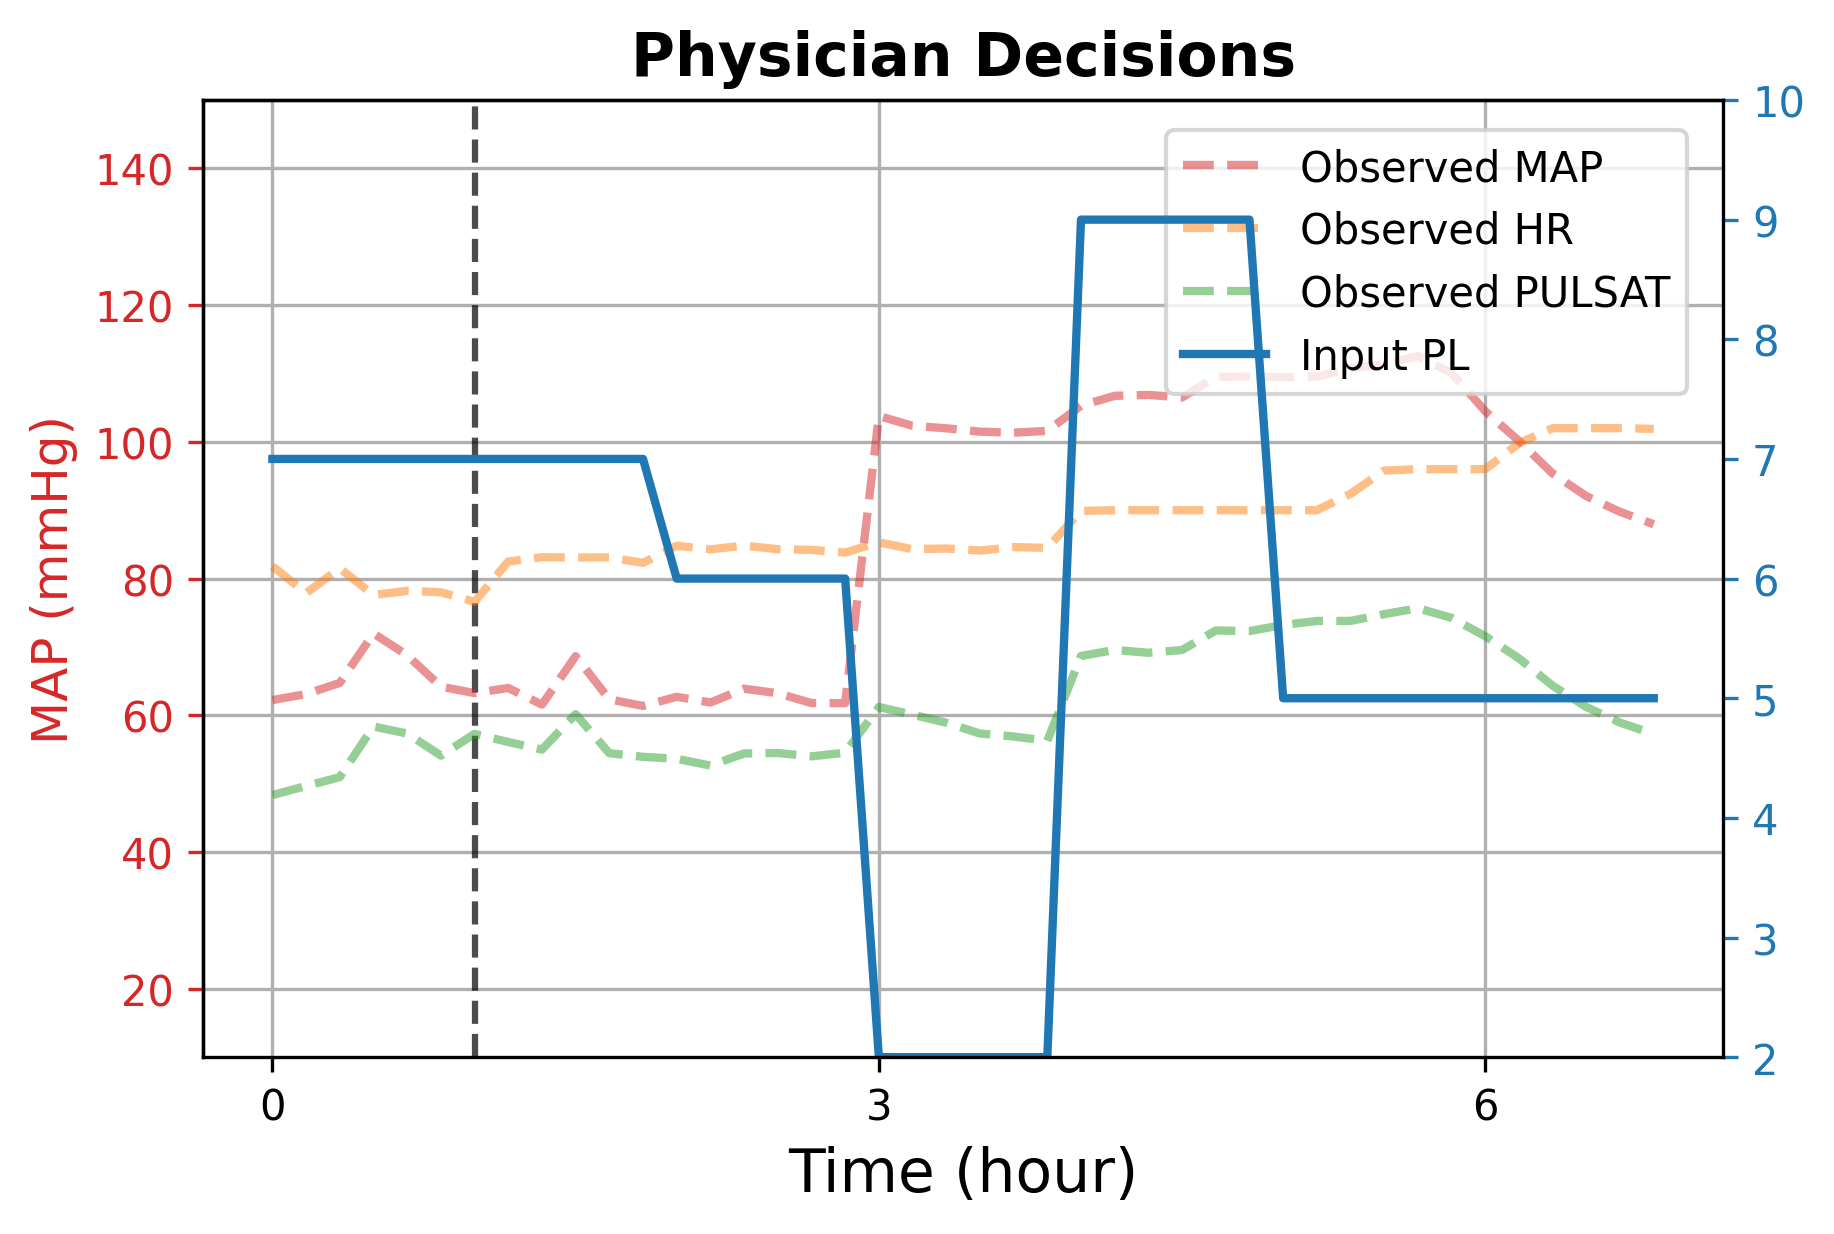

ACP in this episode 15.0


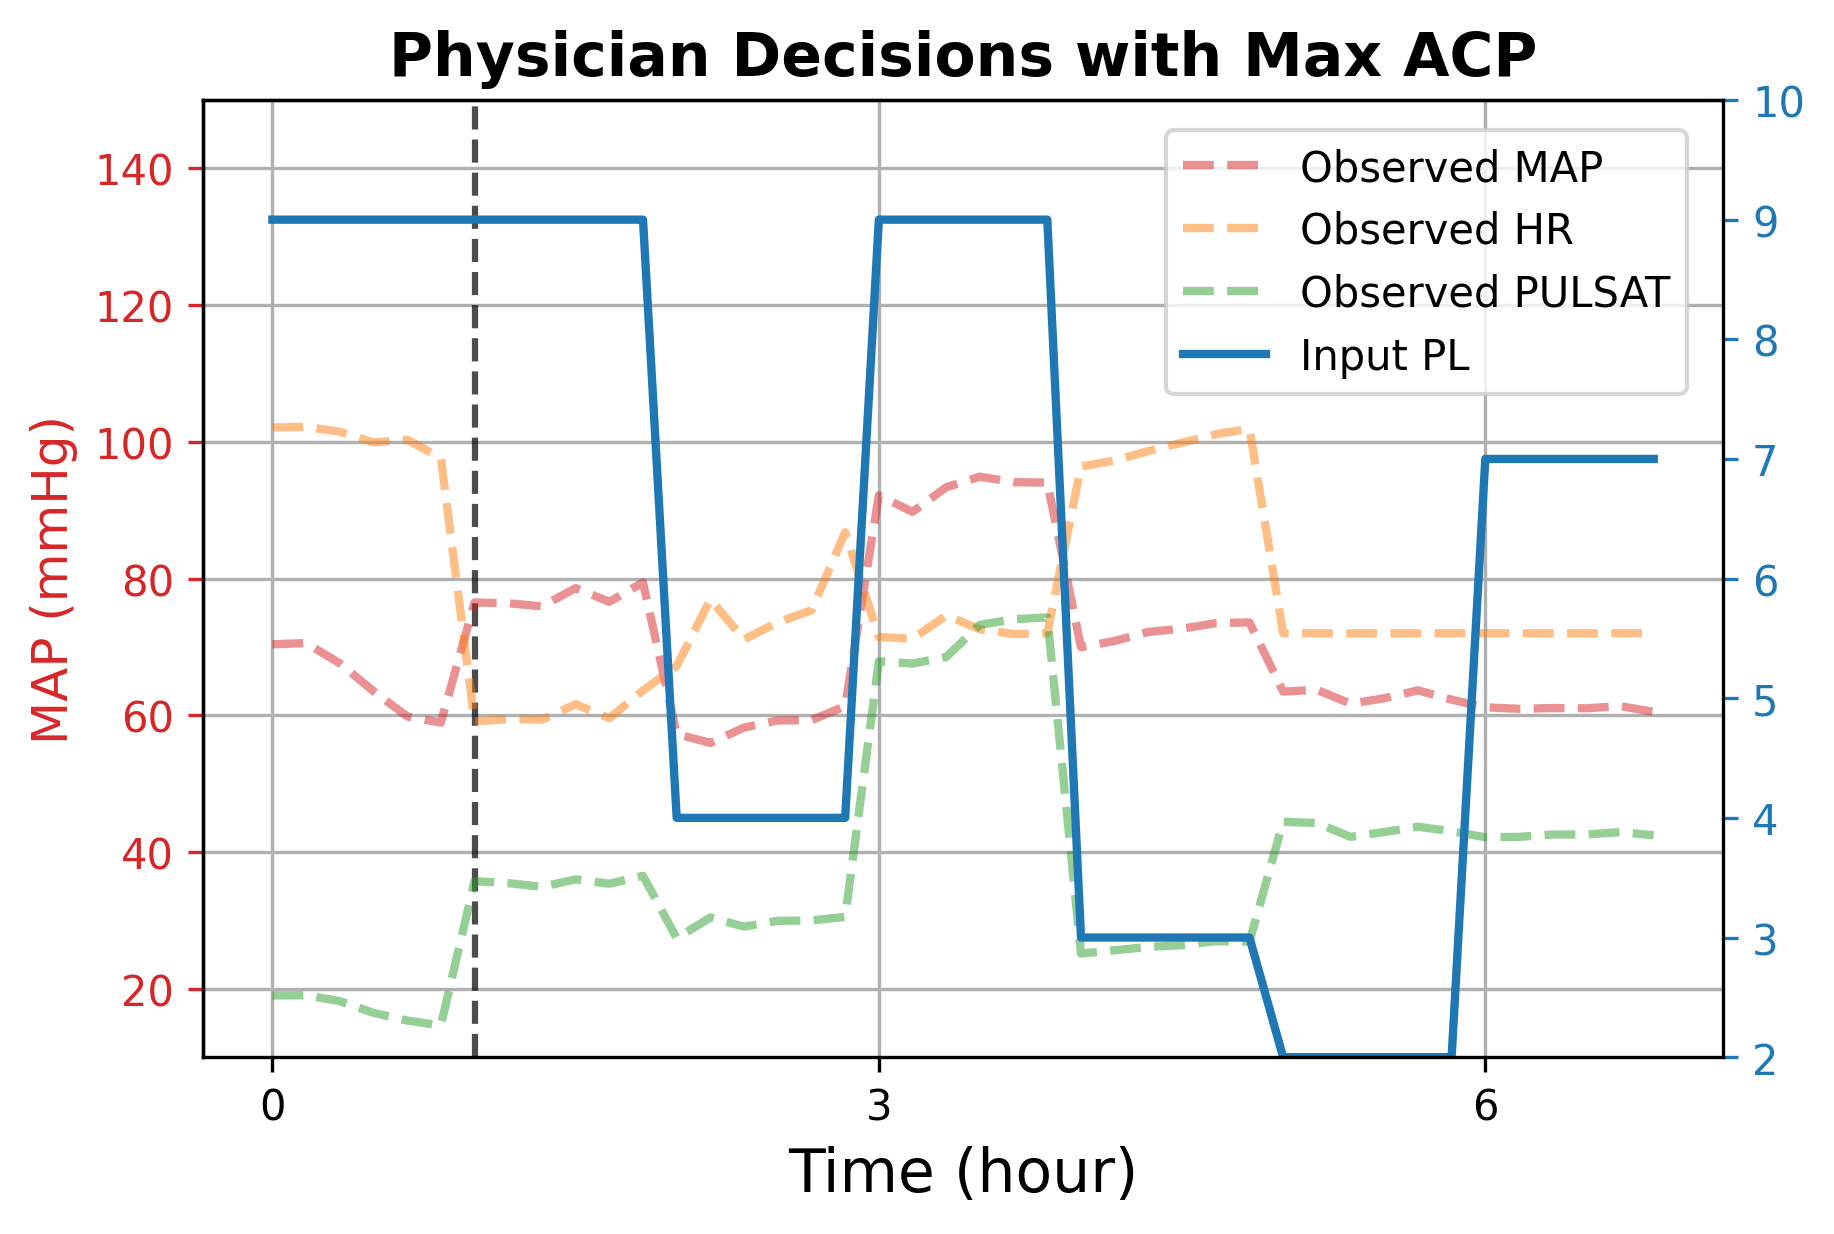

ACP in this episode 21.0
Mean normalized reward per episode: 0.3712
Mean ACP per episode: 1.7863
Mean Aggregate AIR per episode: 0.4282
Mean Super Metric per episode: 0.0000
Mean Weaning Score per episode: 0.0442
Mean Weaning Score Merged per episode: 0.0681
Mean Weaning Score Threshold per episode: 0.0764
percentage of episodes with acp > 2.0 29.166666666666668 | max ACP in an episode 21.0 | min ACP in an episode 0.0
percentage of episodes with ws <= 0 0.0 | max Weaning Score in an episode 2.0 | min Weaning Score in an episode -1.0


In [15]:
acp_list6, ws_list6, all_normalized_rewards6, slope_list6 = data_based_eval(sliced_data_episodic6, episode_len6, eval_episodes6)

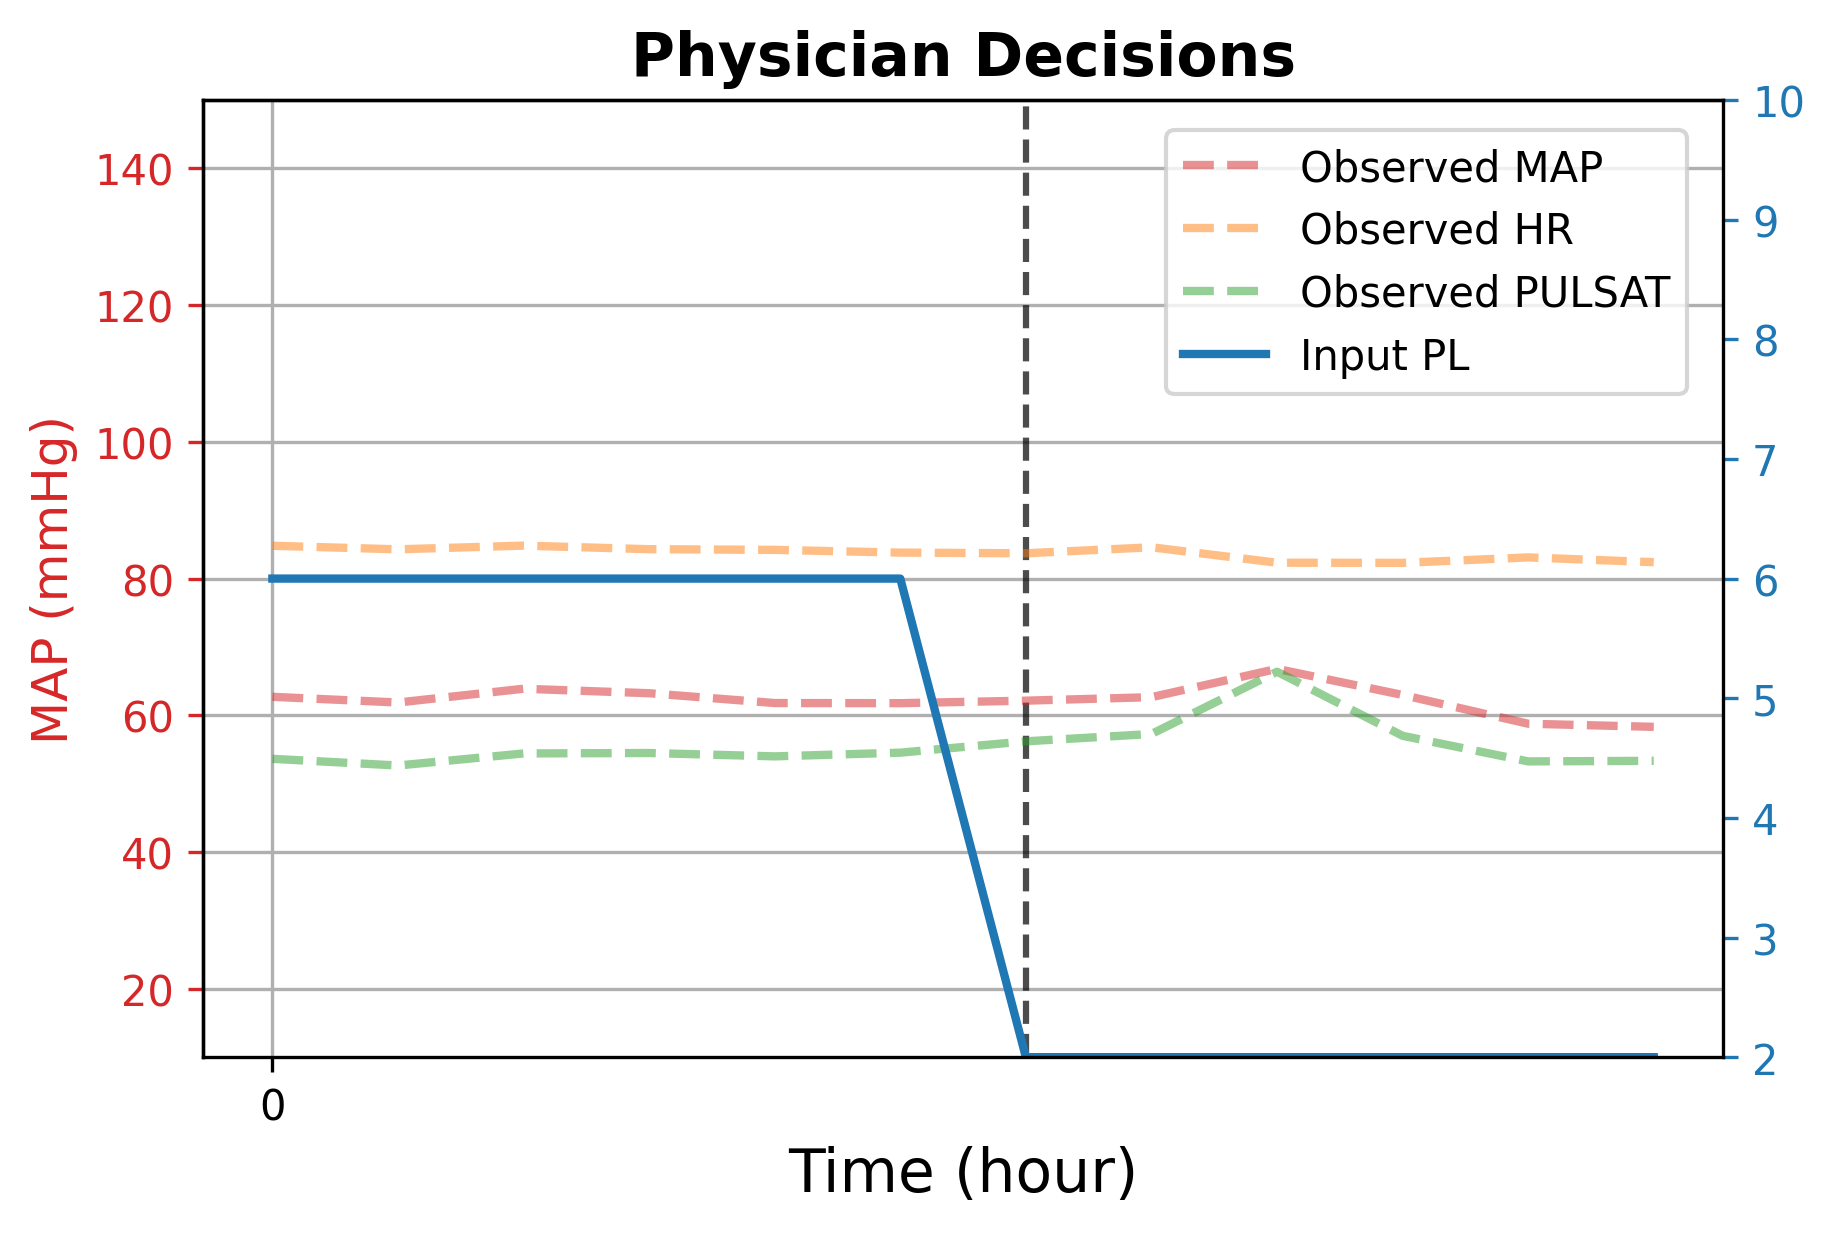

ACP in this episode 4.0
Mean normalized reward per episode: 0.0619
Mean ACP per episode: 0.0347
Mean Aggregate AIR per episode: 0.6319
Mean Super Metric per episode: 0.0000
Mean Weaning Score per episode: 0.0276
Mean Weaning Score Merged per episode: 0.0511
Mean Weaning Score Threshold per episode: 0.0439
percentage of episodes with acp > 2.0 0.9184587813620072 | max ACP in an episode 7.0 | min ACP in an episode 0.0
percentage of episodes with ws <= 0 0.0 | max Weaning Score in an episode 2.0 | min Weaning Score in an episode -1.0


In [50]:
acp_list1, ws_list1, all_normalized_rewards1, slope_list1 = data_based_eval(sliced_data_episodic1, episode_len1, eval_episodes1)

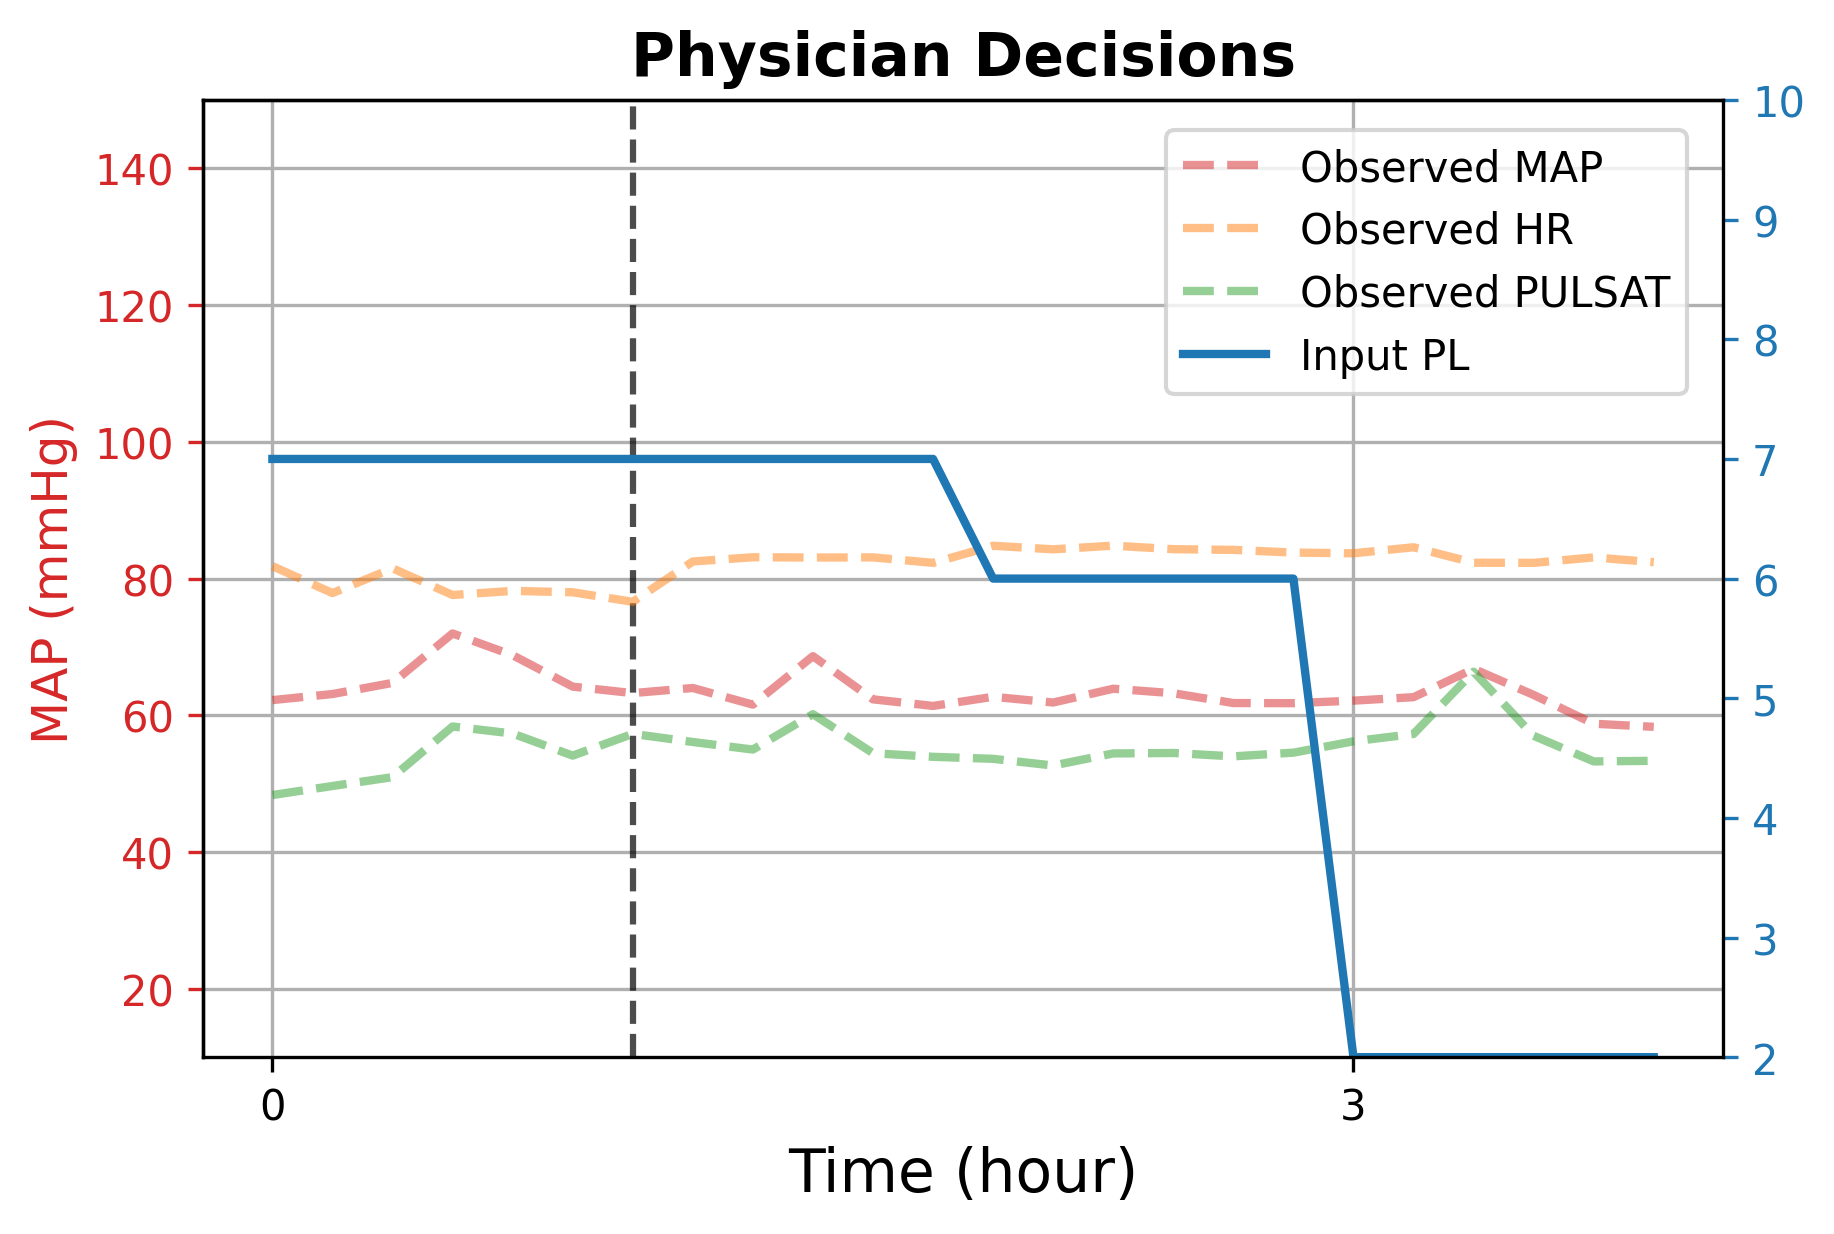

ACP in this episode 4.0
Mean normalized reward per episode: 0.1856
Mean ACP per episode: 0.7312
Mean Aggregate AIR per episode: 0.5301
Mean Super Metric per episode: 0.0000
Mean Weaning Score per episode: 0.0448
Mean Weaning Score Merged per episode: 0.0720
Mean Weaning Score Threshold per episode: 0.0702
percentage of episodes with acp > 2.0 15.255376344086022 | max ACP in an episode 16.0 | min ACP in an episode 0.0
percentage of episodes with ws <= 0 0.0 | max Weaning Score in an episode 2.0 | min Weaning Score in an episode -1.0


In [51]:
acp_list3, ws_list3, all_normalized_rewards3, slope_list3 = data_based_eval(sliced_data_episodic3, episode_len3, eval_episodes3)

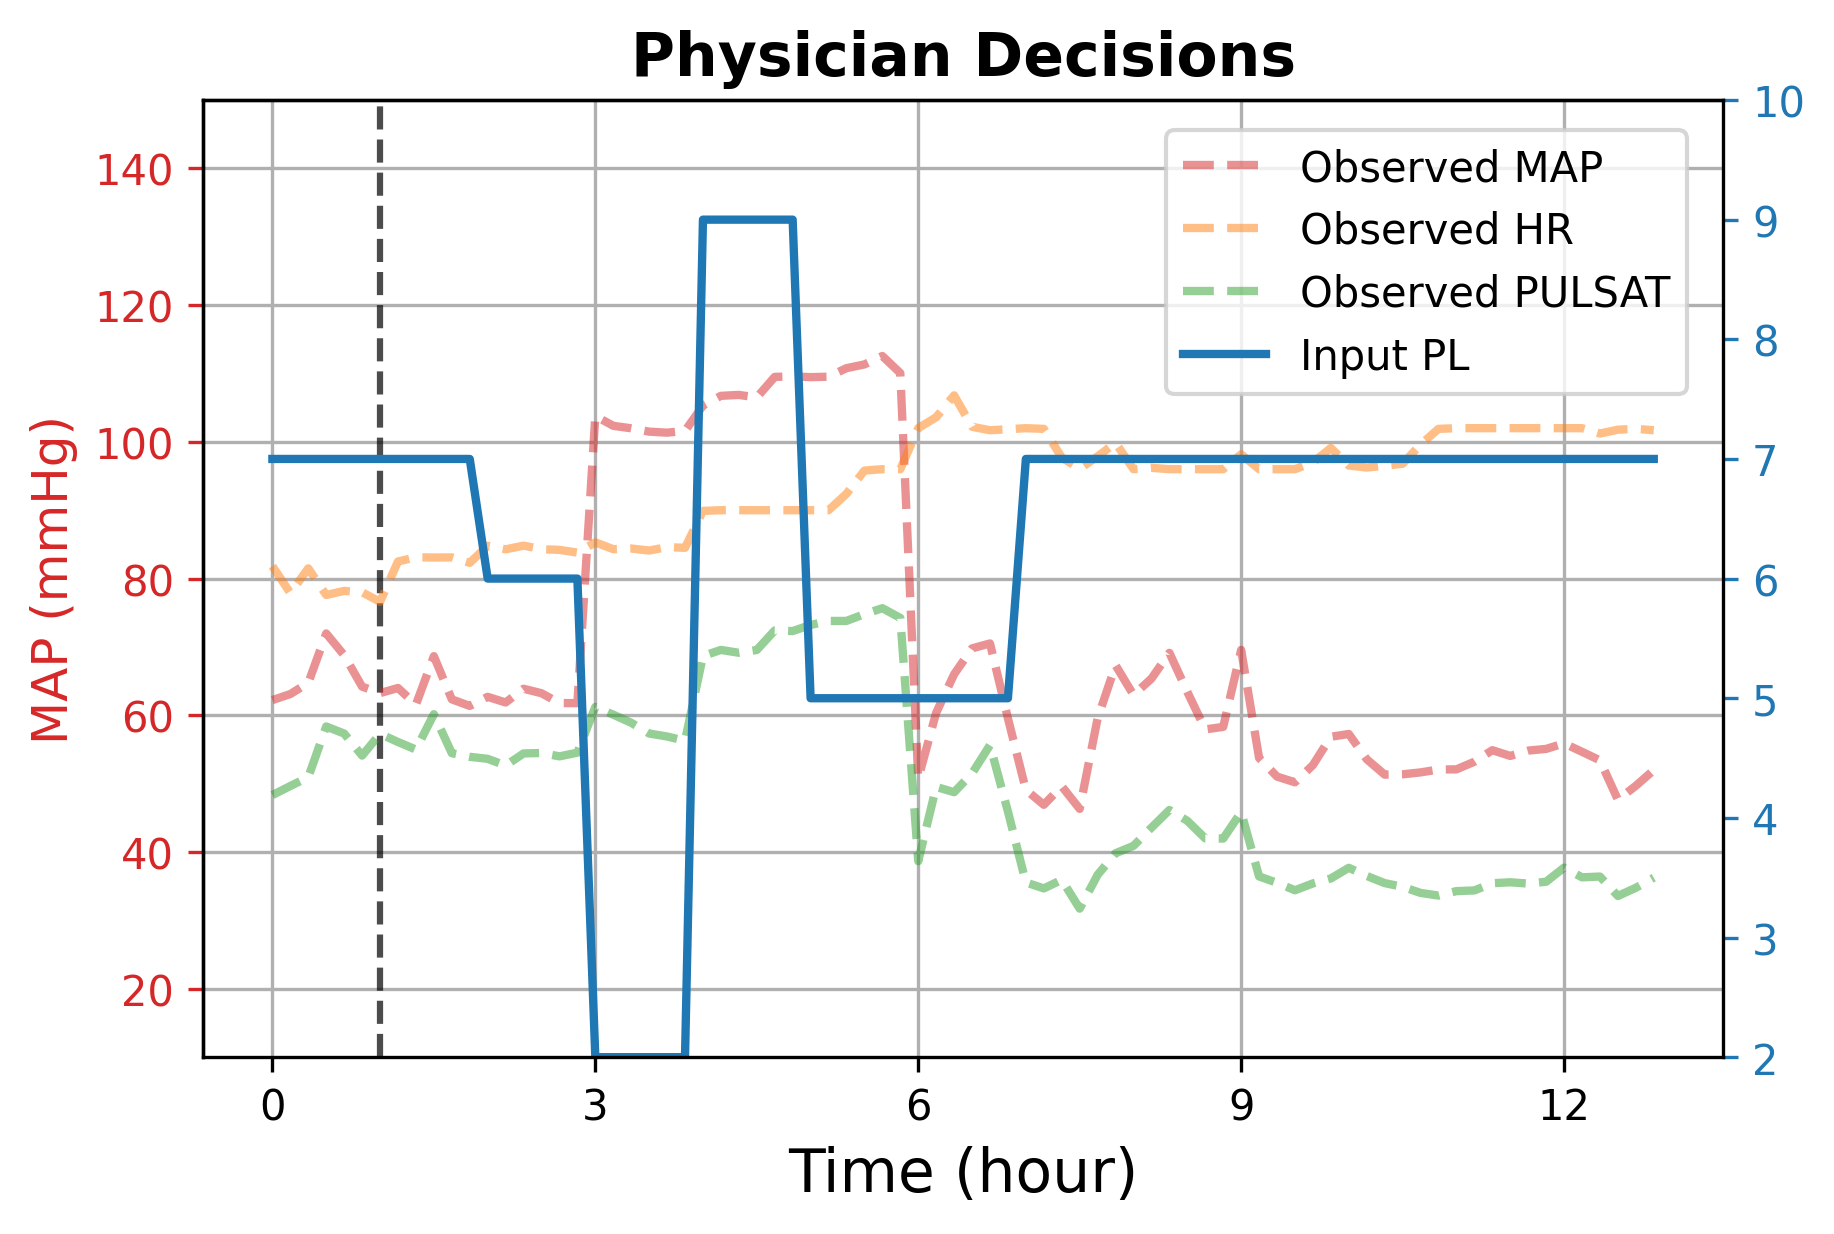

ACP in this episode 15.0


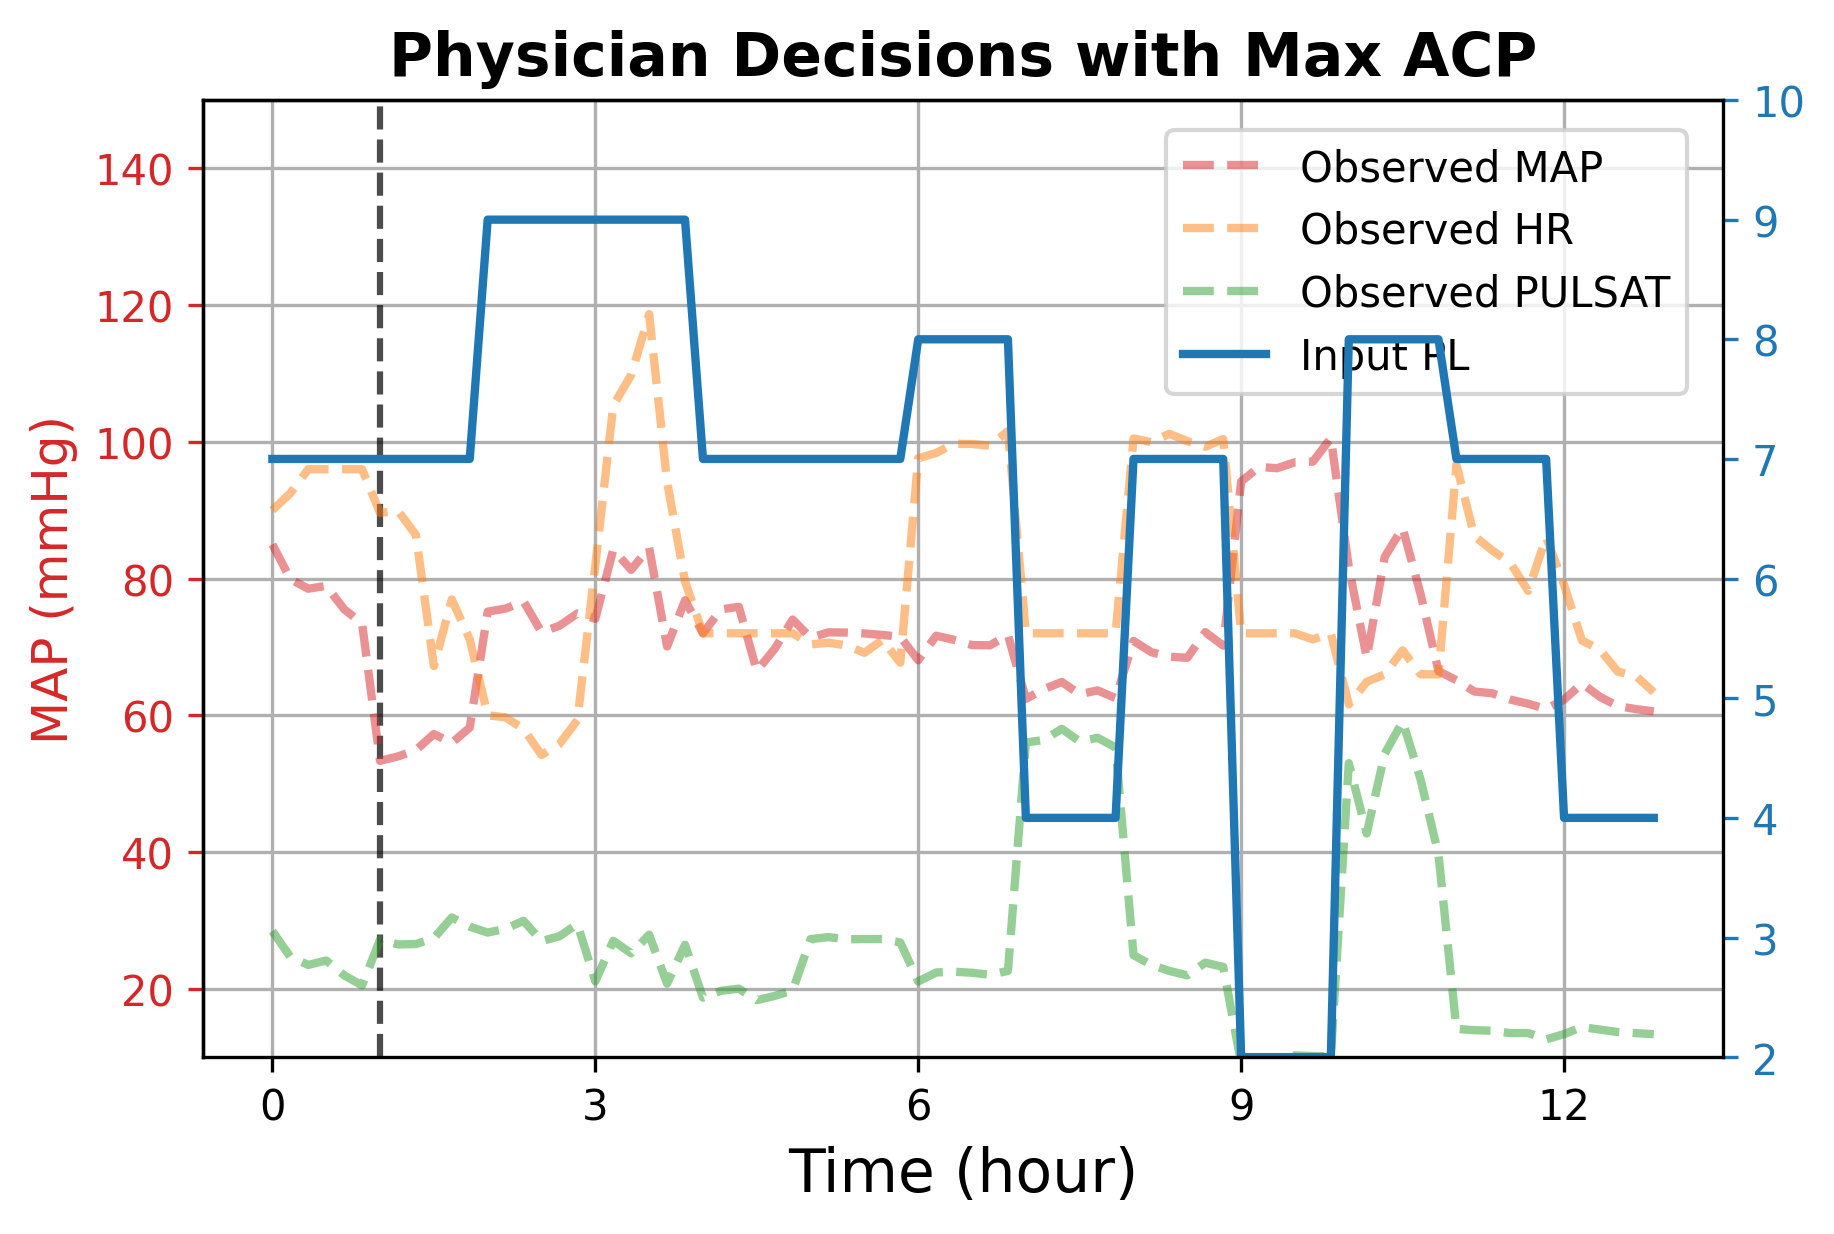

ACP in this episode 21.0
Mean normalized reward per episode: 0.7424
Mean ACP per episode: 4.0215
Mean Aggregate AIR per episode: 0.3182
Mean Super Metric per episode: 0.0000
Mean Weaning Score per episode: 0.0487
Mean Weaning Score Merged per episode: 0.0711
Mean Weaning Score Threshold per episode: 0.0936
percentage of episodes with acp > 2.0 48.924731182795696 | max ACP in an episode 40.0 | min ACP in an episode 0.0
percentage of episodes with ws <= 0 0.0 | max Weaning Score in an episode 1.0 | min Weaning Score in an episode -1.0


In [65]:
acp_list12, ws_list12, all_normalized_rewards12, slope_list12 = data_based_eval(sliced_data_episodic12, episode_len12, eval_episodes12)

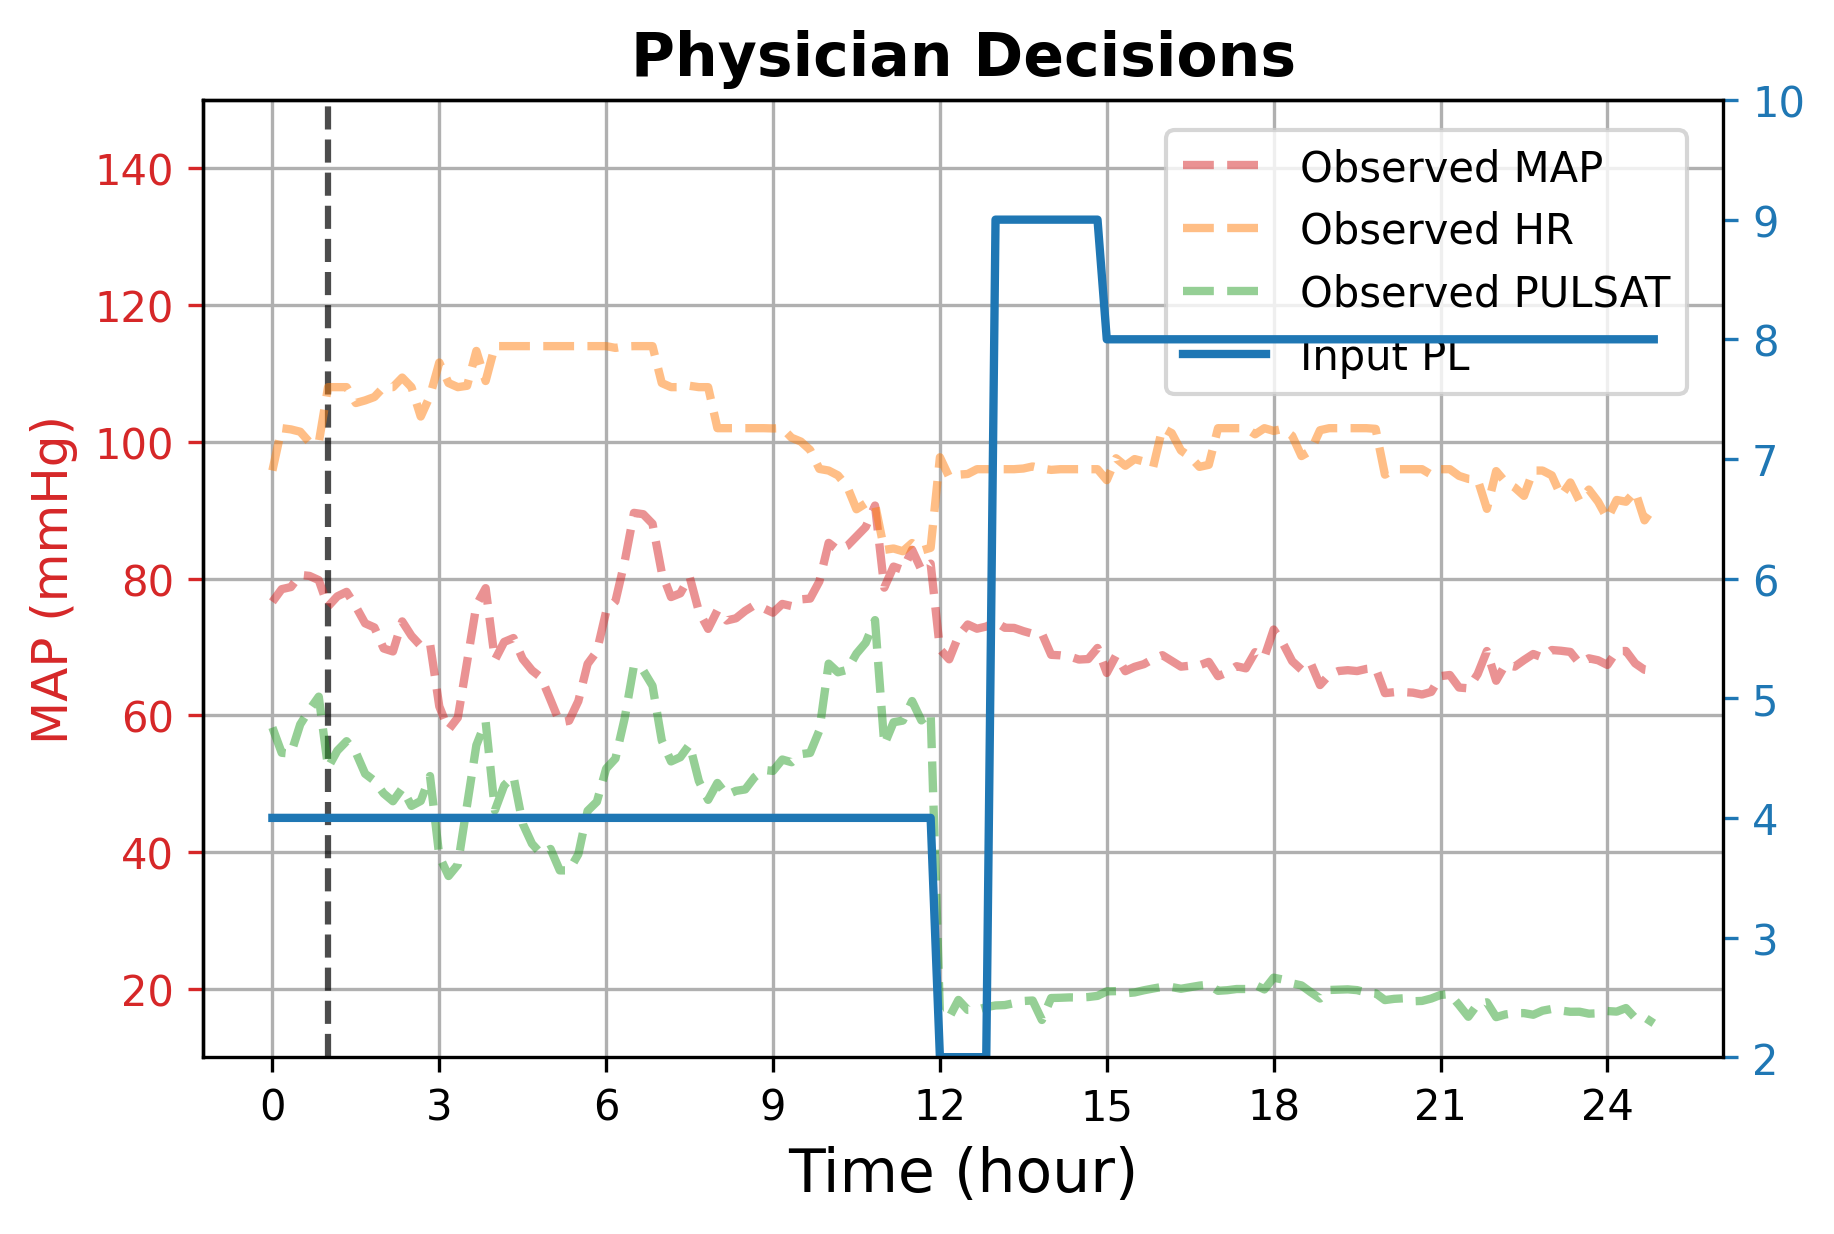

ACP in this episode 7.0
Mean normalized reward per episode: 1.4849
Mean ACP per episode: 8.4247
Mean Aggregate AIR per episode: 0.2249
Mean Super Metric per episode: 0.0000
Mean Weaning Score per episode: 0.0519
Mean Weaning Score Merged per episode: 0.0714
Mean Weaning Score Threshold per episode: 0.0909
percentage of episodes with acp > 2.0 70.96774193548387 | max ACP in an episode 56.0 | min ACP in an episode 0.0
percentage of episodes with ws <= 0 0.0 | max Weaning Score in an episode 0.8 | min Weaning Score in an episode -0.5555555555555556


In [56]:
acp_list24, ws_list24, all_normalized_rewards24, slope_list24 = data_based_eval(sliced_data_episodic24, episode_len24, eval_episodes24)

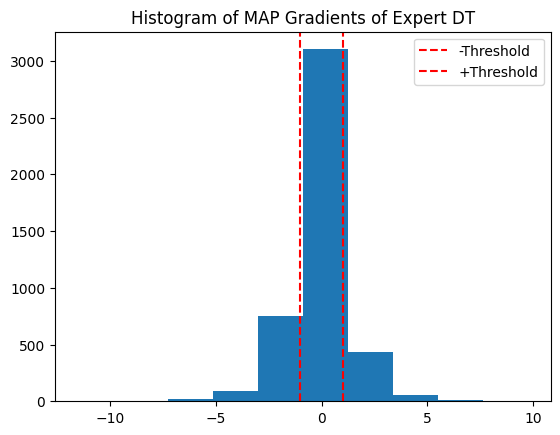

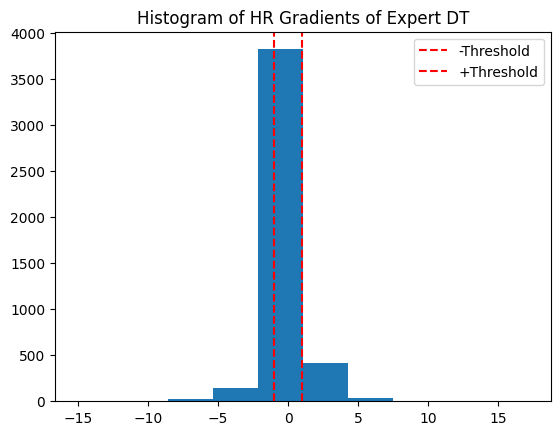

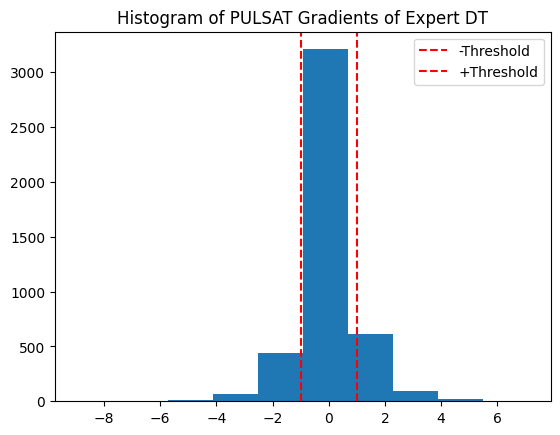

In [11]:
np_slope = np.array(slope_list).reshape(-1,3)
plt.hist(np_slope[:,0])
plt.title('Histogram of MAP Gradients of Expert DT')

plt.axvline(x=-1, color='red', linestyle='--', label='-Threshold')
plt.axvline(x=1, color='red', linestyle='--', label='+Threshold')
plt.legend()

plt.show()
plt.hist(np_slope[:,1])
plt.axvline(x=-1, color='red', linestyle='--', label='-Threshold')
plt.axvline(x=1, color='red', linestyle='--', label='+Threshold')
plt.title('Histogram of HR Gradients of Expert DT')
plt.legend()

plt.show()
plt.hist(np_slope[:,2])
plt.axvline(x=-1, color='red', linestyle='--', label='-Threshold')
plt.axvline(x=1, color='red', linestyle='--', label='+Threshold')
plt.title('Histogram of PULSAT Gradients of Expert DT')
plt.legend()
plt.show()

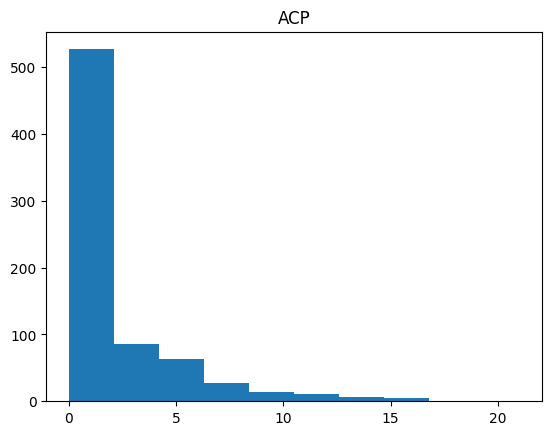

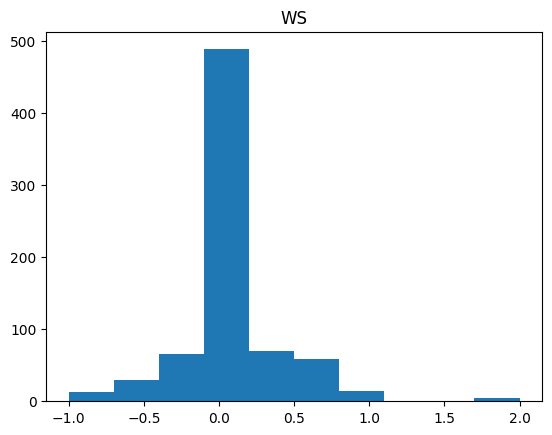

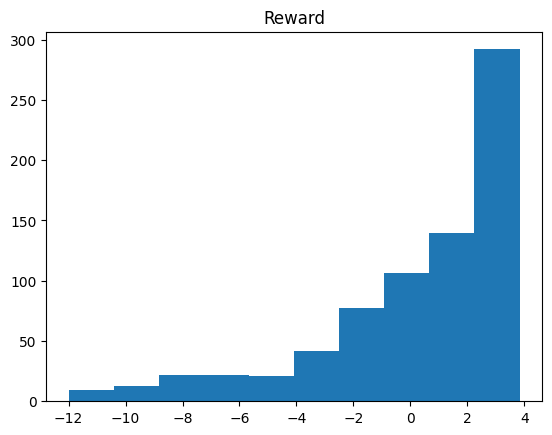

In [12]:
plt.hist(acp_list)
plt.title('ACP')
plt.show()
plt.hist(ws_list)
plt.title('WS')
plt.show()
plt.hist(all_normalized_rewards)
plt.title('Reward')
plt.show()

## DT-based Metrics

In [60]:
def dt_based_evaluation(sliced_state_episodic, sliced_next_state_episodic, episode_len, eval_episodes):
    
    eval_env = AbiomedRLEnvFactory.create_env(
                                        model_name="10min_1hr_all_data",
                                        model_path=None,
                                        data_path=None,
                                        max_steps=6,
                                        action_space_type="continuous",
                                        reward_type="smooth",
                                        normalize_rewards=True,
                                        seed=42,
                                        device = f"cuda:1" if torch.cuda.is_available() else "cpu",
                                        )

    avg_reward = 0.0
    avg_acp = 0.0
    avg_wean_merged = 0.0
    avg_wean_thr = 0.0
    # ---- aggregated metrics over episodes ----
    total_map_air_sum = 0.0
    total_hr_air_sum = 0.0
    total_pulsatility_air_sum = 0.0
    total_aggregate_air_sum = 0.0
    total_unstable_percentage_sum = 0.0
    total_unstable_percentage_gradient_sum = 0.0
    total_unstable_percentage_merged_sum = 0.0
    total_super_sum = 0.0
    wean_score_sum = 0.0
    slope_list = []

    num_acp = 0.0
    num_ws = 0.0
    acp_list = []
    ws_list = []
    rwd_list = []
    plotted = 0
    for k in range(eval_episodes):
        ep_states = []           # store normalized states per step (like in _evaluate)
        actions = []
        avg_reward = 0
        for t in range(episode_len):
            action = sliced_next_state_episodic[k, t, :, -1]
            action1 = np.array(np.bincount(np.rint(action).astype(int)).argmax())
            state = sliced_state_episodic[k, t, :, col].transpose()
            #normalize the state
            state = (torch.tensor(state) - eval_env.world_model.mean[col]) / eval_env.world_model.std[col]

            with torch.no_grad():
                next_state = eval_env.world_model.step(torch.tensor(state).unsqueeze(0), int(action1)).squeeze(0)
            
            reward = eval_env._compute_reward(next_state)
            avg_reward += reward.item()  # accumulate raw reward

            ep_states.append(state.numpy())   # store the *current* obs like _evaluate
            actions.append(int(action1))  # store the *current* action like _evaluate
        rwd_list.append(avg_reward)
        ep_states_np = np.asarray(ep_states, dtype=np.float32) #normalized
        action_np = np.asarray(actions, dtype=np.int32) #unnormalized

        wm = getattr(eval_env, 'world_model', None)
        if wm is None:
            wm = eval_env.world_model  # fallback to global `env` if that's how you access it

        # AIR metrics
        # total_map_air_sum          += compute_map_physician_air(wm, ep_states_np, eval_env.episode_actions)
        # total_hr_air_sum           += compute_hr_physician_air(wm, ep_states_np, eval_env.episode_actions)
        # total_pulsatility_air_sum  += compute_pulsatility_physician_air(wm, ep_states_np, eval_env.episode_actions)
        acp = compute_acp_cost_model(wm,action_np,ep_states_np)
        acp_list.append(acp)
        avg_acp += acp
        total_aggregate_air_sum    += aggregate_air_model(wm, ep_states_np, action_np)
        total_super_sum            += super_metric(wm, ep_states_np, action_np)
        ws, slopes = weaning_score_model_gradient(wm, ep_states_np, action_np)
        slope_list.append(slopes)
        ws_list.append(ws)
        wean_score_sum             += ws
        ws_merged = weaning_score_model_merged(wm, ep_states_np, action_np)
        avg_wean_merged  += ws_merged 
        ws_thr = weaning_score_model(wm, ep_states_np, action_np)
        avg_wean_thr += ws_thr

    


        # if acp >= 3.0: 
        #     num_acp +=1
        #     if num_acp == 1:
        #         episode_states.append(next_state.numpy())
        #         plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions", legend=True)
        #         print('ACP in this episode', acp)
        #     if acp == 21:
        #         episode_states.append(next_state.numpy())
        #         plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Max ACP",legend=True)
        #         print('ACP in this episode', acp)
            # if acp == 3:
            #     episode_states.append(next_state.numpy())
            #     plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with ACP=2",legend=True)
            #     print('ACP in this episode', acp)
        # if ws <= 0.0:
        #     num_ws +=1
        #     if num_ws == 1:
        #         episode_states.append(next_state.numpy())
        #         plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Weaning Score 0",legend=True)
        #         print('Weaning score in this episode', ws)
        #     if ws == -1.0:
        #         episode_states.append(next_state.numpy())
        #         plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Min Weaning Score",legend=True)
        #         print('Weaning score in this episode', ws)
        
        # if (ws == 2.0) and (plotted== 0):
        #     plotted = 1
        #     episode_states.append(next_state.numpy())
        #     plot_policy(np.array(episode_states), np.array(episode_actions), "Physician Decisions with Max Weaning Score",legend=True)
        #     print('Weaning score in this episode', ws)
        uns_thr  =  unstable_percentage_model(wm, ep_states_np)   
        total_unstable_percentage_sum +=uns_thr
        uns_gradient = unstable_percentage_model_gradient(wm, ep_states_np)
        total_unstable_percentage_gradient_sum += uns_gradient
        uns_merged = unstable_percentage_model_merged(wm, ep_states_np)
        total_unstable_percentage_merged_sum += uns_merged
        if (uns_merged == 100) and (plotted == 0):
            plotted += 1
            ep_states.append(next_state.cpu().numpy())
            plot_policy(np.array(ep_states), action_np, f"Physician Decisions with Clinical WS = {ws_thr}", eval_env, legend=True)
            print('WS MERGED', ws_merged, 'Unstable hours merged', uns_merged)
            print("Unstable hours threshold", uns_thr, "Unstable hours gradient", uns_gradient)
        if (uns_gradient == 100) and (uns_thr==0) and (plotted == 1):
            plotted += 1
            ep_states.append(next_state.cpu().numpy())
            plot_policy(np.array(ep_states), action_np, f"Physician Decisions with Gradient WS = {ws}", eval_env, legend=True)
            print('WS MERGED', ws_merged, 'Unstable hours merged', uns_merged)
            print("Unstable hours threshold", uns_thr, "Unstable hours gradient", uns_gradient)
        if (uns_thr == 100) and (uns_gradient==0) and (plotted == 2):
            plotted = 3
            ep_states.append(next_state.cpu().numpy())
            plot_policy(np.array(ep_states), action_np, f"Physician Decisions Merged WS = {ws_merged}", eval_env, legend=True)
            print('WS MERGED', ws_merged, 'Unstable hours merged', uns_merged)
            print("Unstable hours threshold", uns_thr, "Unstable hours gradient", uns_gradient)



    # ---- episode averages ----
    # avg_reward /= eval_episodes
    avg_reward = np.mean(rwd_list)
    acp_mean = avg_acp / eval_episodes
    wean_merged_mean = avg_wean_merged / eval_episodes
    wean_thr = avg_wean_thr / eval_episodes


    map_air_mean          = total_map_air_sum / eval_episodes
    hr_air_mean           = total_hr_air_sum / eval_episodes
    puls_air_mean         = total_pulsatility_air_sum / eval_episodes
    aggregate_air_mean    = total_aggregate_air_sum / eval_episodes
    unstable_hours_mean   = total_unstable_percentage_sum / eval_episodes
    unstable_hours_gradient_mean   = total_unstable_percentage_gradient_sum / eval_episodes
    unstable_hours_merged_mean = total_unstable_percentage_merged_sum/eval_episodes
    weaning_score_mean    = wean_score_sum / eval_episodes
    super_mean            = total_super_sum / eval_episodes

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: "
            f"Return {avg_reward:.3f}")
    print(f"ACP {acp_mean:.4f}")
    # print(f"MAP AIR/ep: {map_air_mean:.5f} | HR AIR/ep: {hr_air_mean:.5f} "
    #         f"| Pulsatility AIR/ep: {puls_air_mean:.5f}")
    print(f"Aggregate AIR/ep: {aggregate_air_mean:.5f}")
    print(f"Unstable hours (%): {unstable_hours_mean}")
    print(f"Unstable hours gradient (%): {unstable_hours_gradient_mean}")
    print(f"Unstable hours merged (%): {unstable_hours_merged_mean}")
    print(f"Weaning score: {weaning_score_mean}")
    print(f"Weaning score merged: {wean_merged_mean}")
    print(f"Weaning score thr: {wean_thr}")
    print(f"Super metric: {super_mean:.5f}")
    print("---------------------------------------")
    return acp_list, ws_list, rwd_list, slope_list

<module 'noisy_mujoco.abiomed_env.config' from '/home/ubuntu/noisy_mujoco/abiomed_env/config.py'>
time series transformer device cuda:1
Using device: cuda:1
Model loaded from /abiomed/downsampled/models/10min_1hr_all_data_model.pth
loaded datasets with length 
 train:  12051 
 val:  1938 
 test:  3876
Data loaded from /abiomed/downsampled/10min_1hr_all_data.pkl
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617


/tmp/ipykernel_282273/3358723293.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = eval_env.world_model.step(torch.tensor(state).unsqueeze(0), int(action1)).squeeze(0)


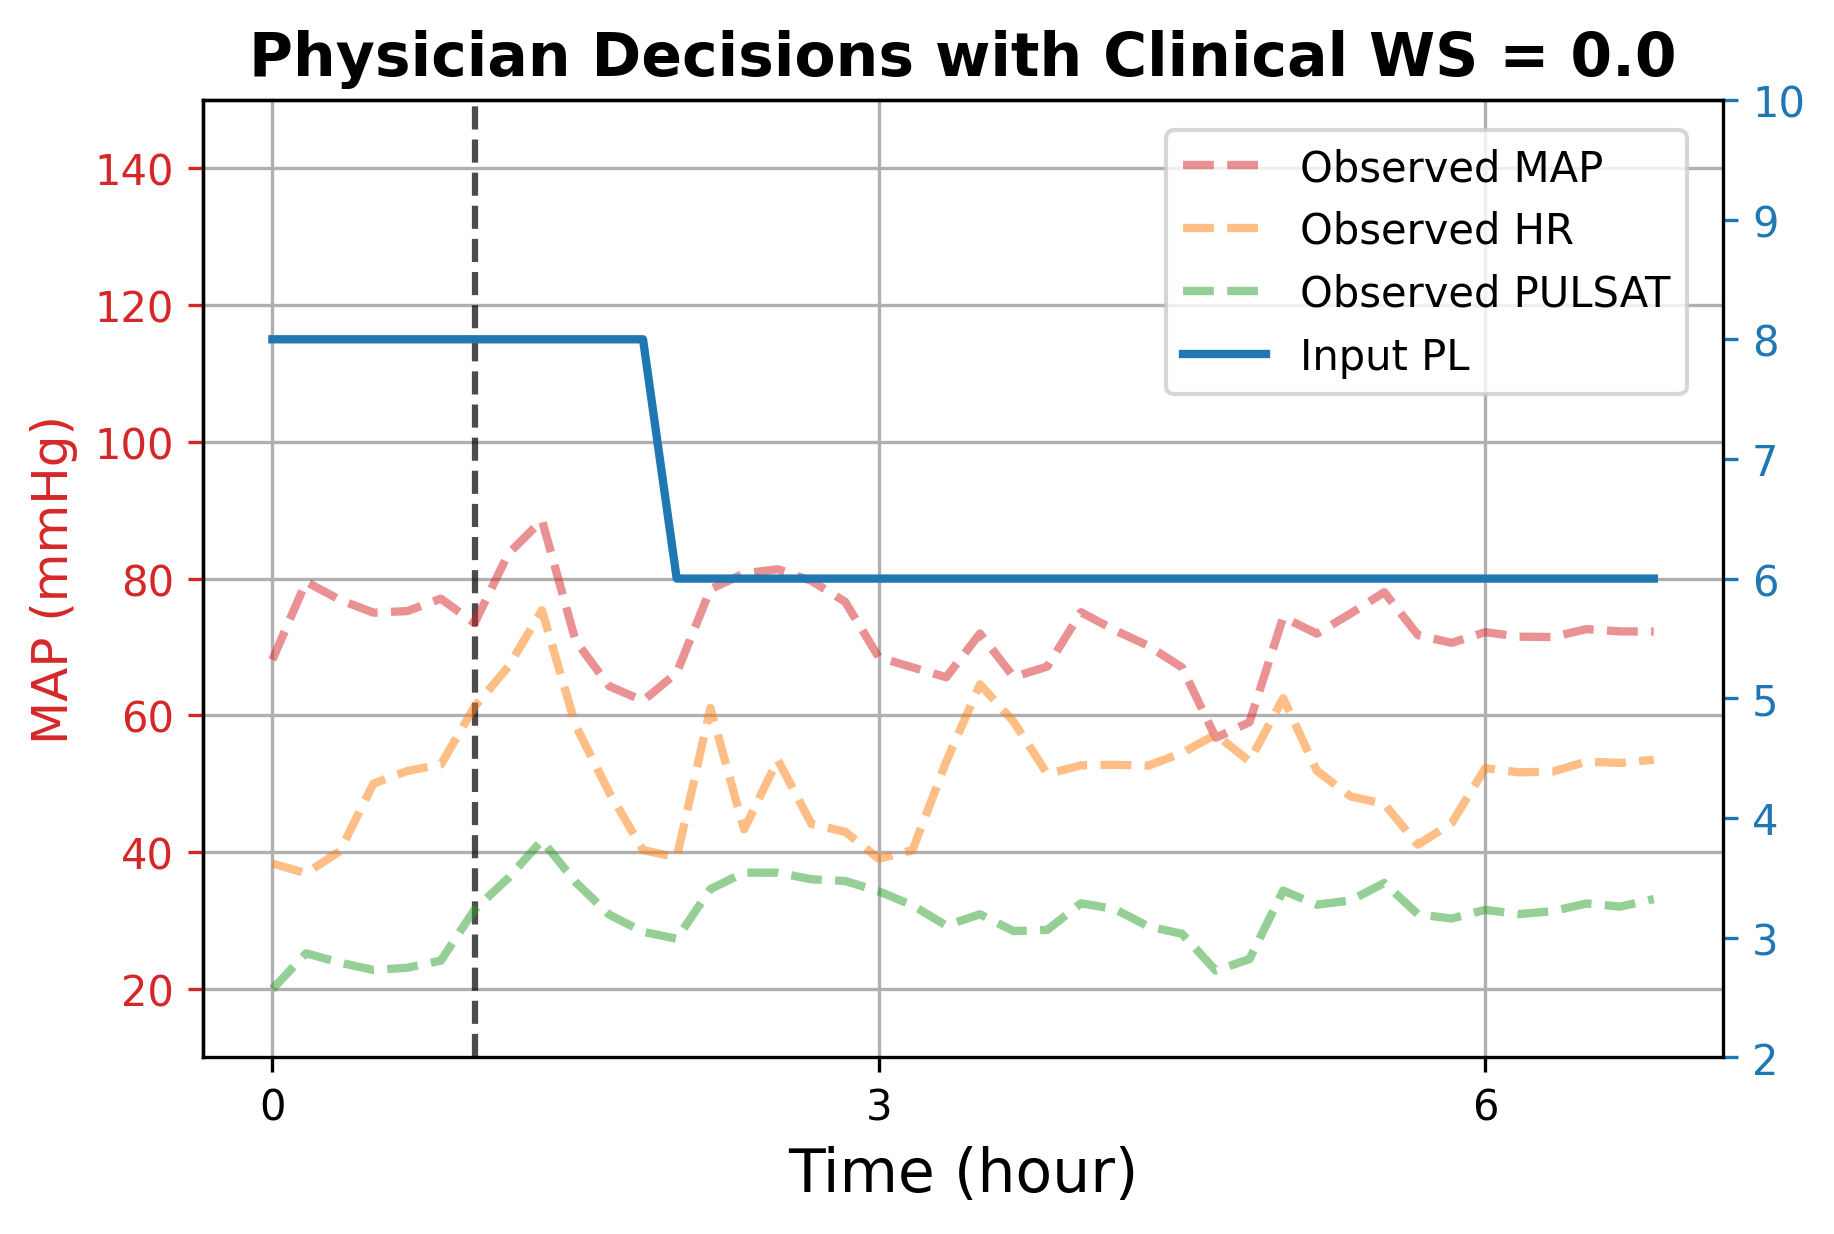

WS MERGED 0.0 Unstable hours merged 100.0
Unstable hours threshold 100.0 Unstable hours gradient 100.0


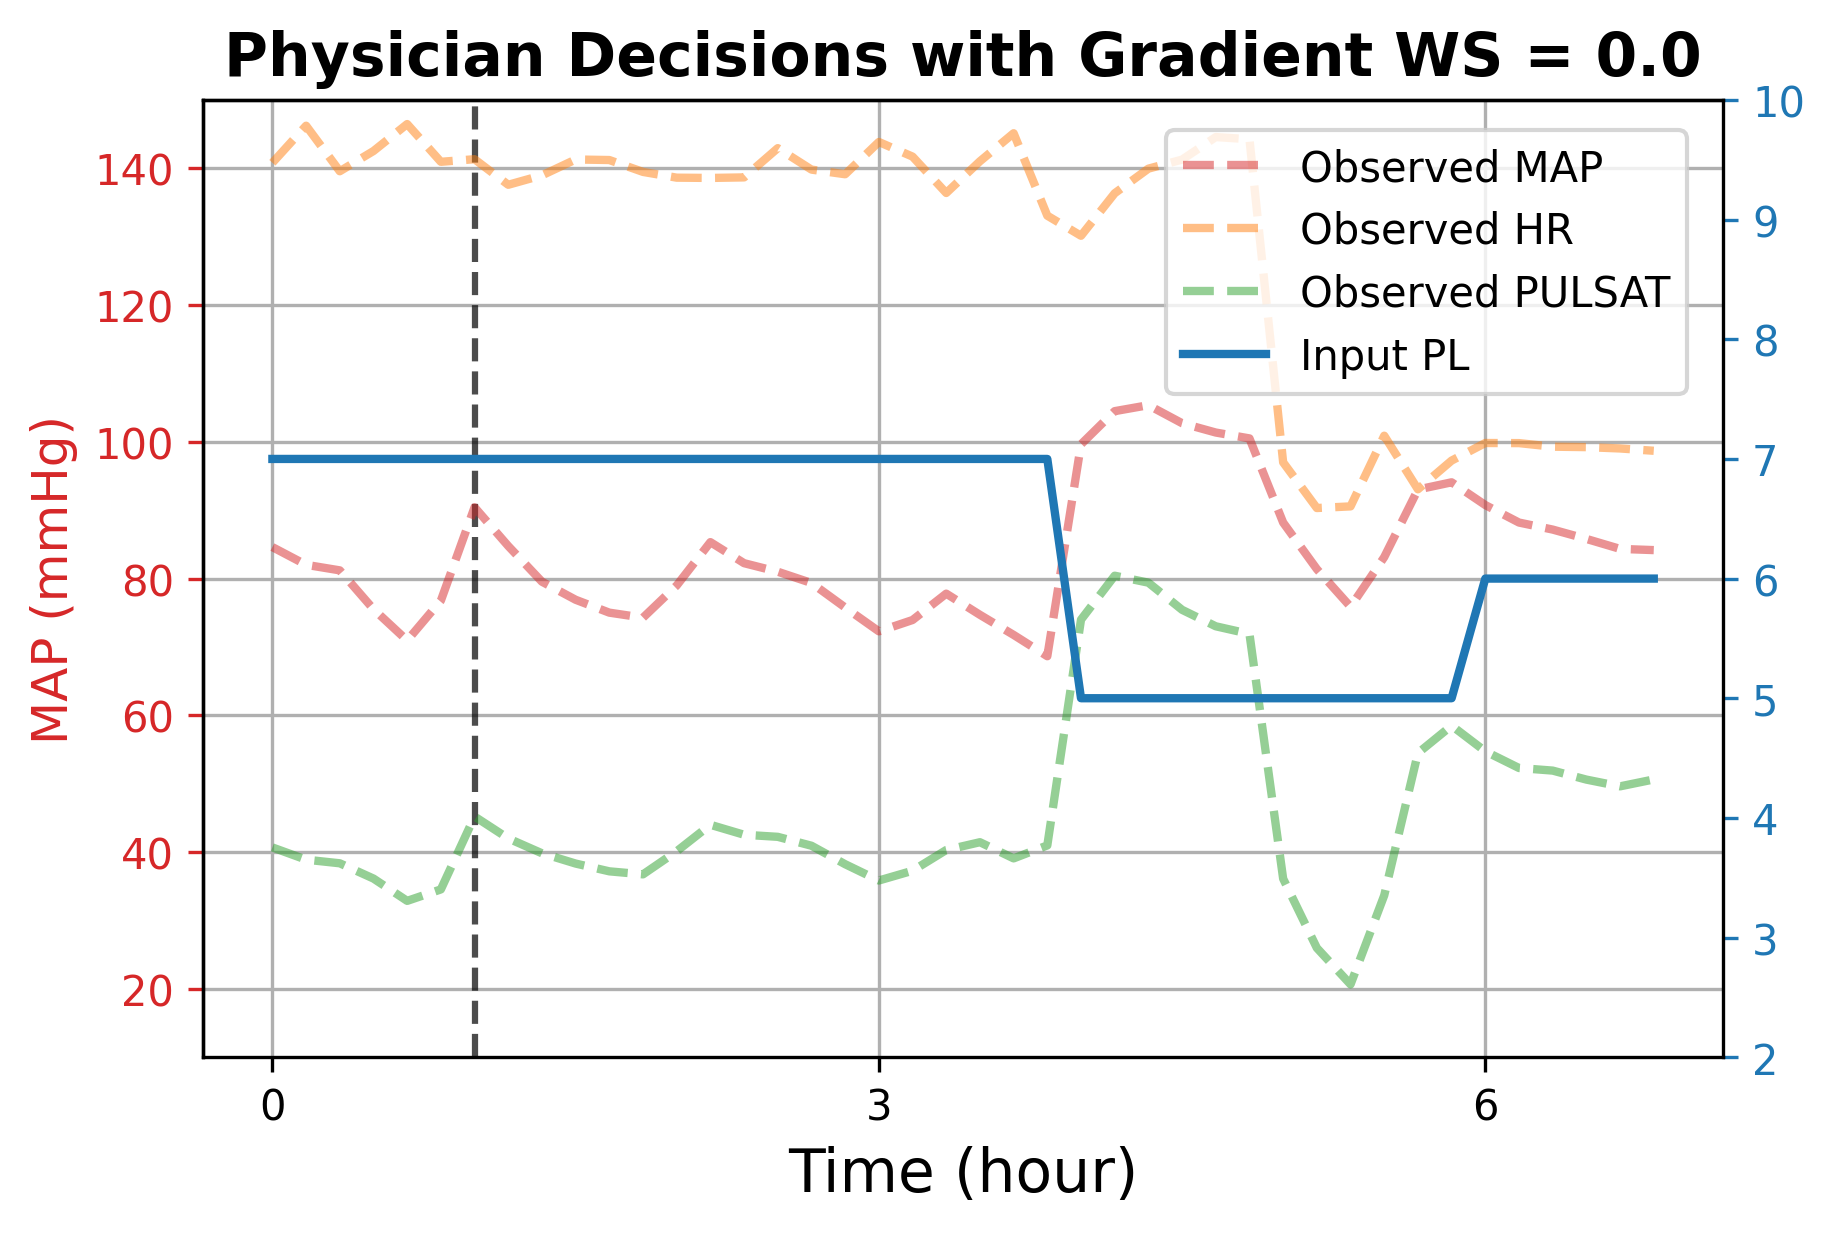

WS MERGED 0.16666666666666666 Unstable hours merged 0.0
Unstable hours threshold 0.0 Unstable hours gradient 100.0


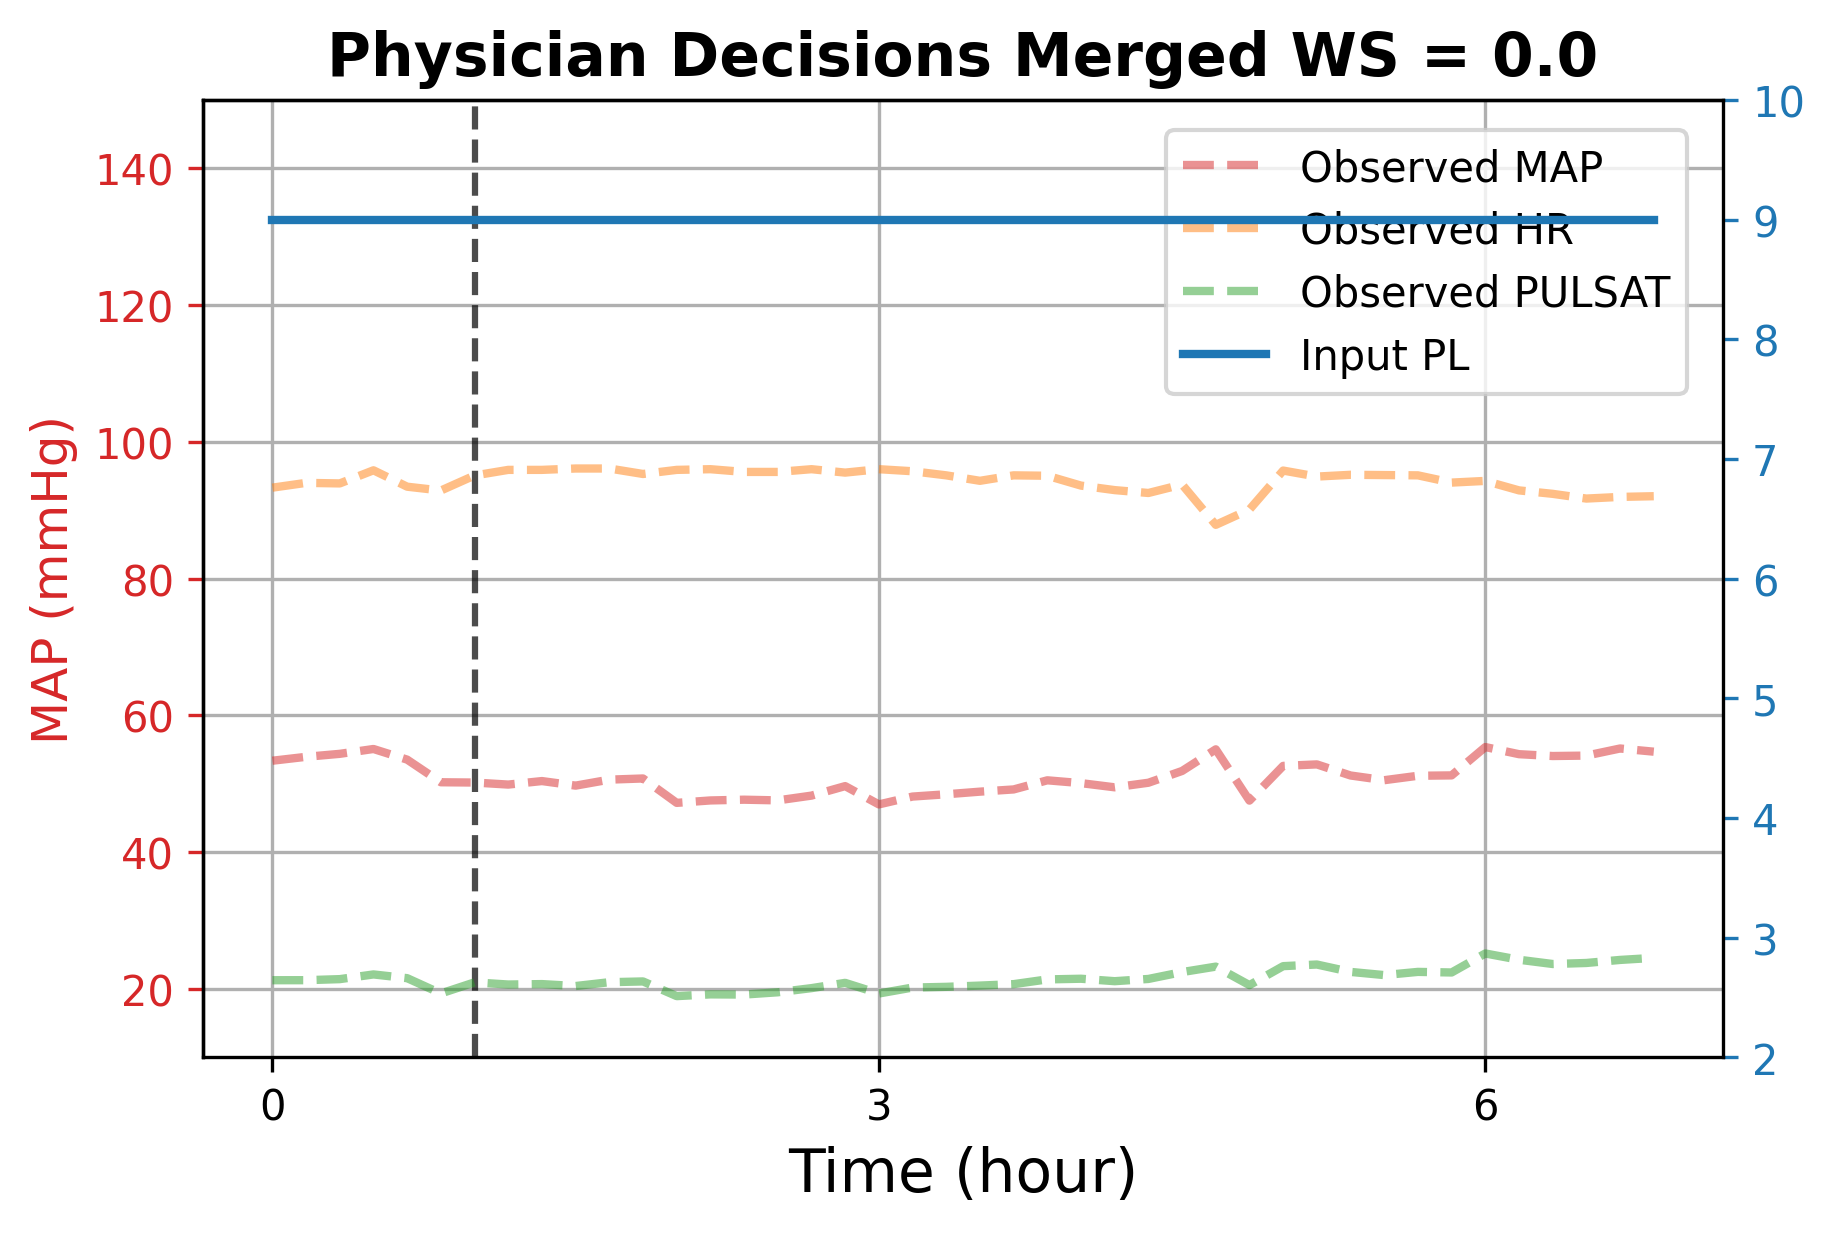

WS MERGED 0.0 Unstable hours merged 0.0
Unstable hours threshold 100.0 Unstable hours gradient 0.0
---------------------------------------
Evaluation over 744 episodes: Return 0.614
ACP 1.7863
Aggregate AIR/ep: 0.42751
Unstable hours (%): 38.08243727598561
Unstable hours gradient (%): 47.75985663082442
Unstable hours merged (%): 19.780465949820787
Weaning score: 0.04415322580645162
Weaning score merged: 0.0680331541218638
Weaning score thr: 0.07641129032258068
Super metric: 1.43414
---------------------------------------


([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  15.0,
  0.0,
  0.0,
  7.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  4.0,
  3.0,
  0.0,
  0.0,
  7.0,
  13.0,
  4.0,
  0.0,
  0.0,
  0.0,
  0.0,
  3.0,
  0.0,
  0.0,
  0.0,
  0.0,
  5.0,
  0.0,
  0.0,
  0.0,
  0.0,
  7.0,
  0.0,
  11.0,
  6.0,
  0.0,
  0.0,
  0.0,
  5.0,
  0.0,
  5.0,
  0.0,
  4.0,
  0.0,
  6.0,
  0.0,
  0.0,
  0.0,
  0.0,
  6.0,
  3.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  6.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  5.0,
  0.0,
  0.0,
  0.0,
  0.0,
  6.0,
  0.0,
  3.0,
  0.0,
  0.0,
  0.0,
  0.0,
  4.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  5.0,
  10.0,
  0.0,
  0.0,
  4.0,
  0.0,
  5.0,
  6.0,
  0.0,
  0.0,
  0.0,
  5.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  4.0,
  0.0,
  5.0,
  0.0,
  0.0,
  5.0,
  5.0,
  3.0,
  6.0,
  0.0,
  6.0,
  0.0,
  

In [61]:
dt_based_evaluation(sliced_state_episodic1, sliced_next_state_episodic1, episode_len1, eval_episodes1)

<module 'noisy_mujoco.abiomed_env.config' from '/home/ubuntu/noisy_mujoco/abiomed_env/config.py'>
time series transformer device cuda:1
Using device: cuda:1
Model loaded from /abiomed/downsampled/models/10min_1hr_all_data_model.pth


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/ubuntu/noisy_mujoco/abiomed_env/model.py:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allow

loaded datasets with length 
 train:  12051 
 val:  1938 
 test:  3876
Data loaded from /abiomed/downsampled/10min_1hr_all_data.pkl
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617


/tmp/ipykernel_282273/3358723293.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = eval_env.world_model.step(torch.tensor(state).unsqueeze(0), int(action1)).squeeze(0)


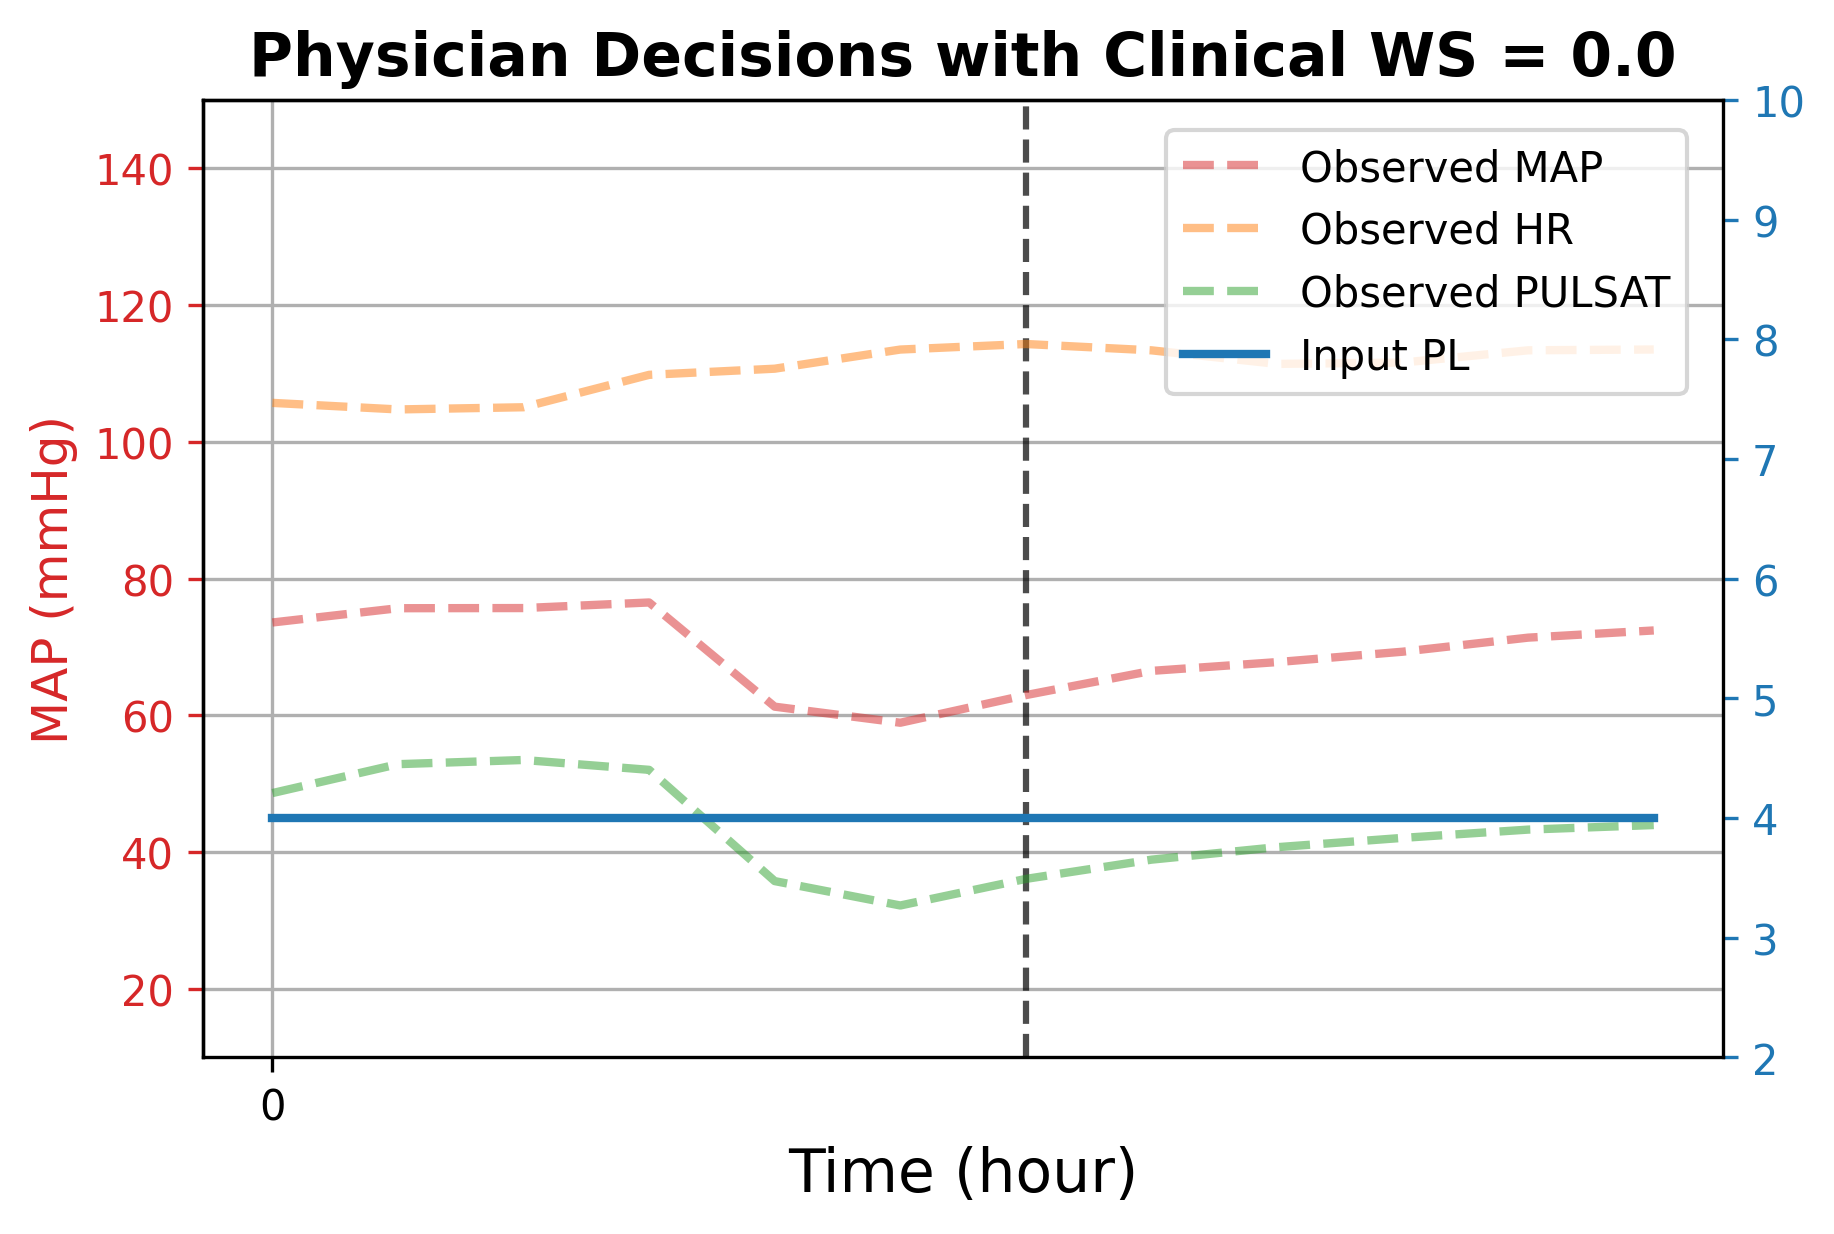

WS MERGED 0.0 Unstable hours merged 100.0
Unstable hours threshold 100.0 Unstable hours gradient 100.0


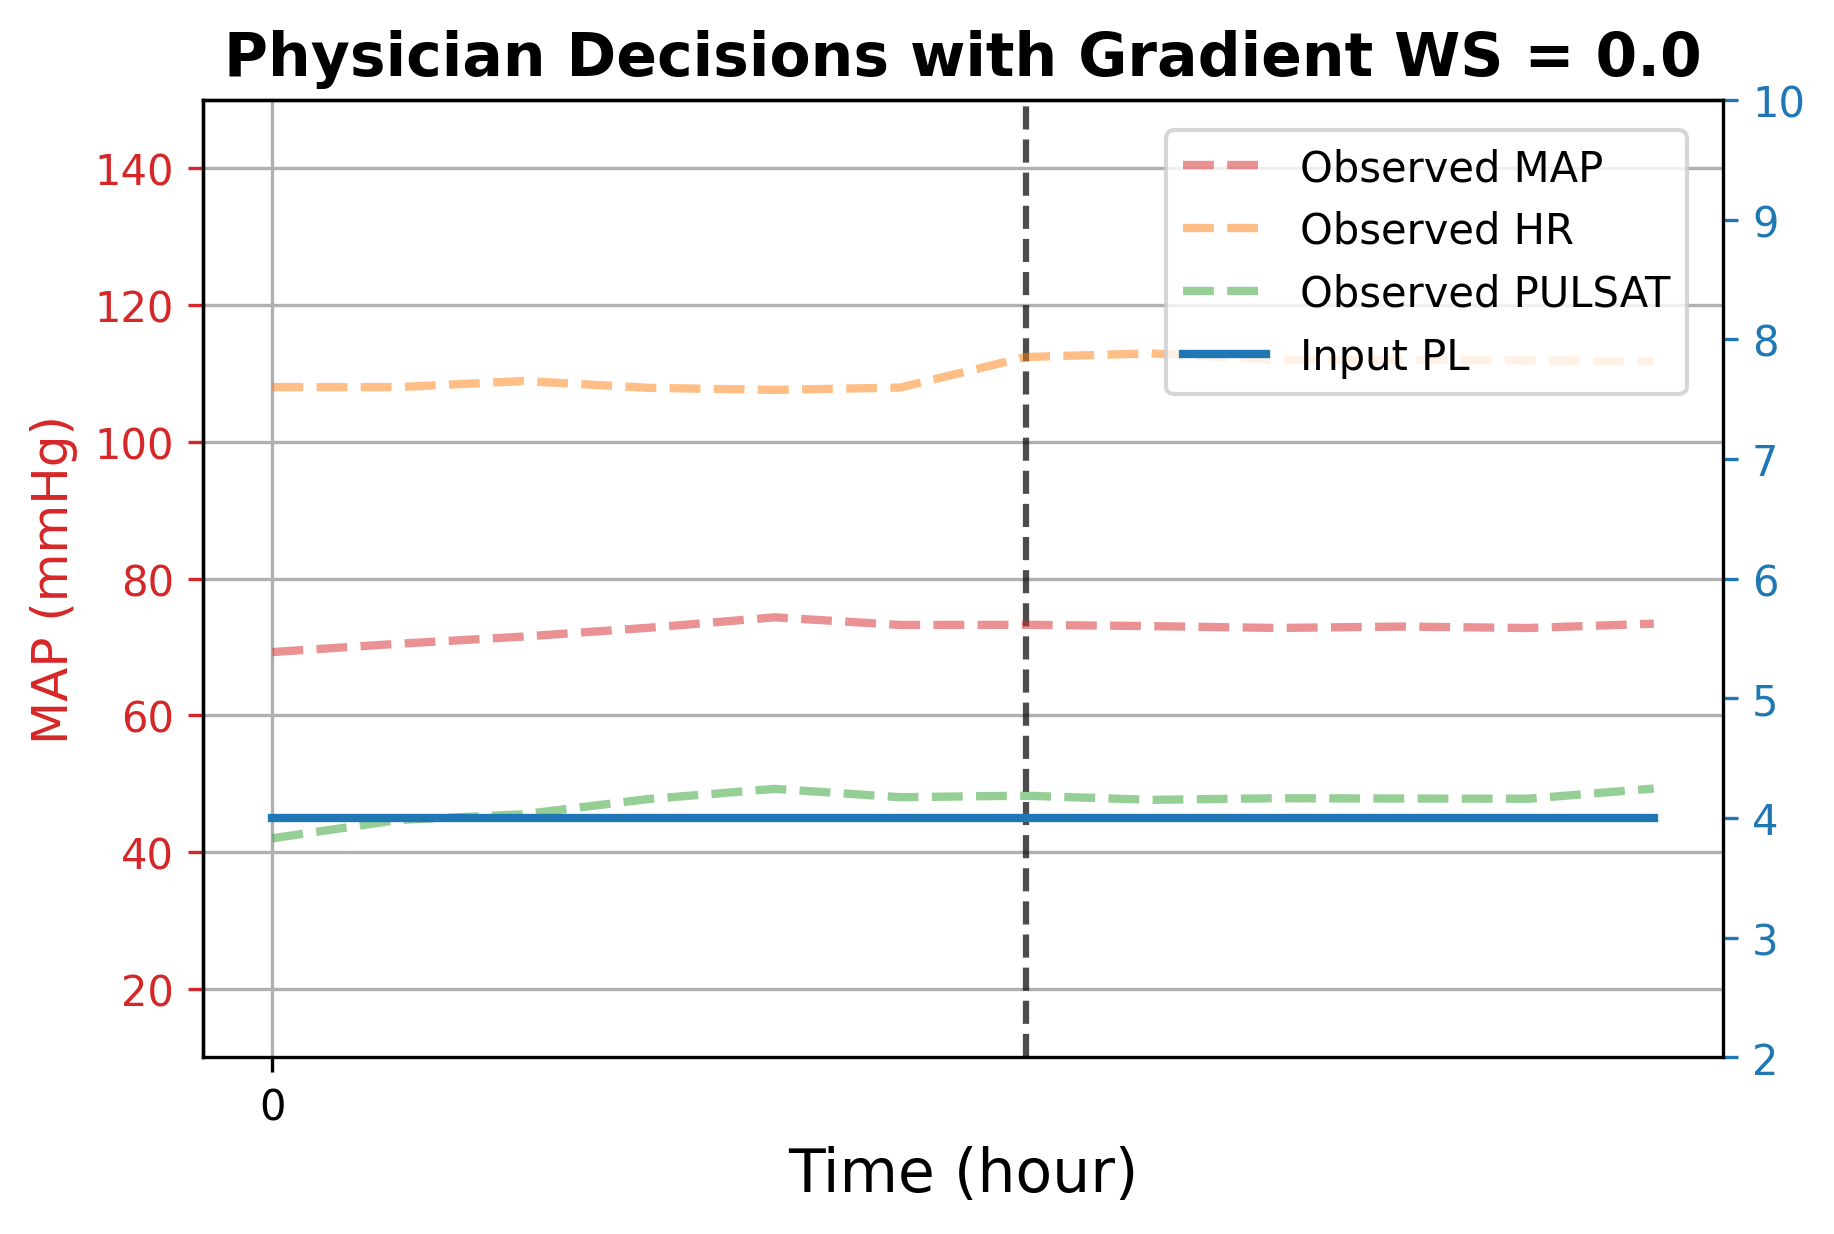

WS MERGED 0.0 Unstable hours merged 0.0
Unstable hours threshold 0.0 Unstable hours gradient 100.0


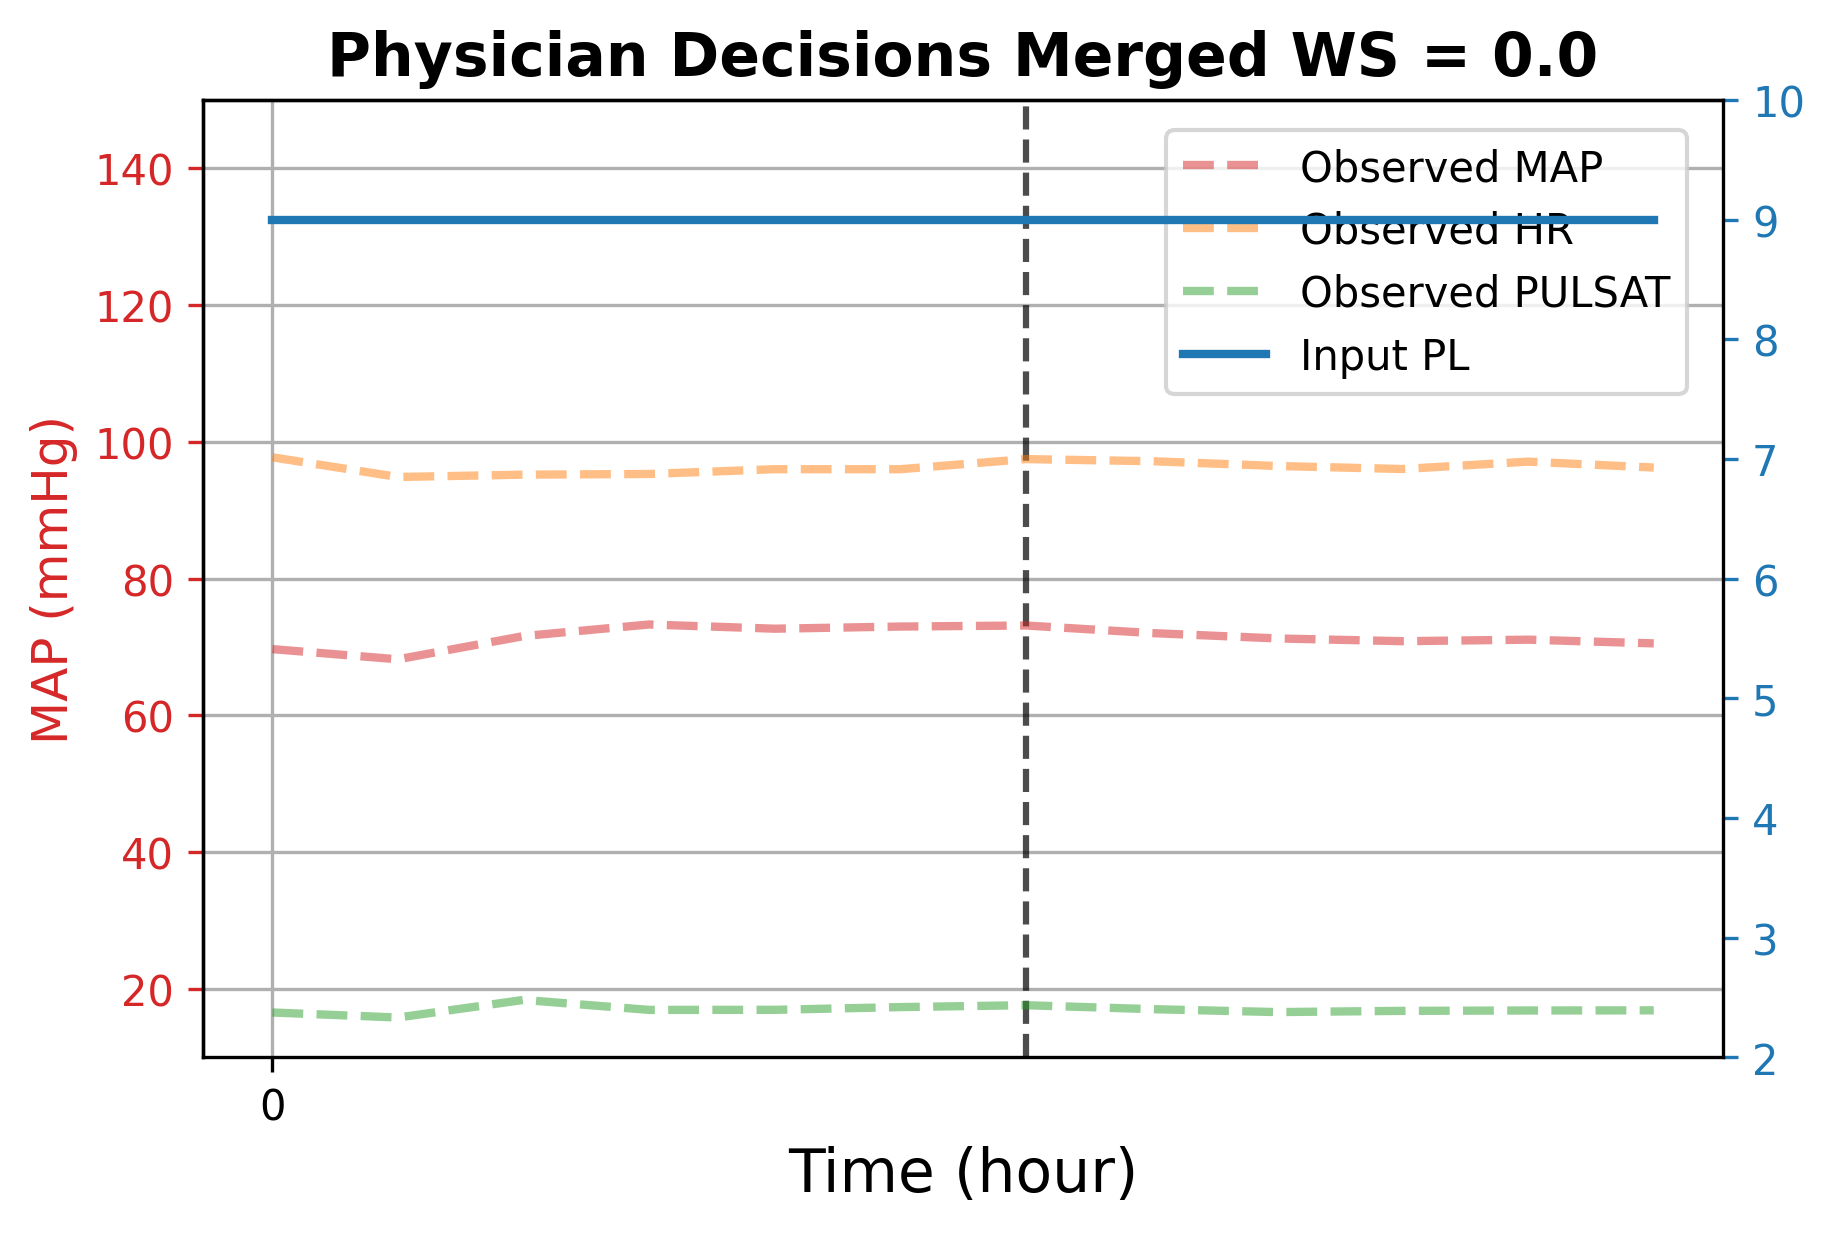

WS MERGED 0.0 Unstable hours merged 0.0
Unstable hours threshold 100.0 Unstable hours gradient 0.0
---------------------------------------
Evaluation over 4464 episodes: Return 0.102
ACP 0.0347
Aggregate AIR/ep: 0.63150
Unstable hours (%): 38.08243727598566
Unstable hours gradient (%): 47.75985663082437
Unstable hours merged (%): 19.780465949820787
Weaning score: 0.027553763440860215
Weaning score merged: 0.051075268817204304
Weaning score thr: 0.04390681003584229
Super metric: 0.00000
---------------------------------------


([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  4.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [62]:
dt_based_evaluation(sliced_state_episodic1, sliced_next_state_episodic1, episode_len1, eval_episodes1)

<module 'noisy_mujoco.abiomed_env.config' from '/home/ubuntu/noisy_mujoco/abiomed_env/config.py'>
time series transformer device cuda:1
Using device: cuda:1
Model loaded from /abiomed/downsampled/models/10min_1hr_all_data_model.pth


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/ubuntu/noisy_mujoco/abiomed_env/model.py:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allow

loaded datasets with length 
 train:  12051 
 val:  1938 
 test:  3876
Data loaded from /abiomed/downsampled/10min_1hr_all_data.pkl
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617


/tmp/ipykernel_282273/3358723293.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = eval_env.world_model.step(torch.tensor(state).unsqueeze(0), int(action1)).squeeze(0)


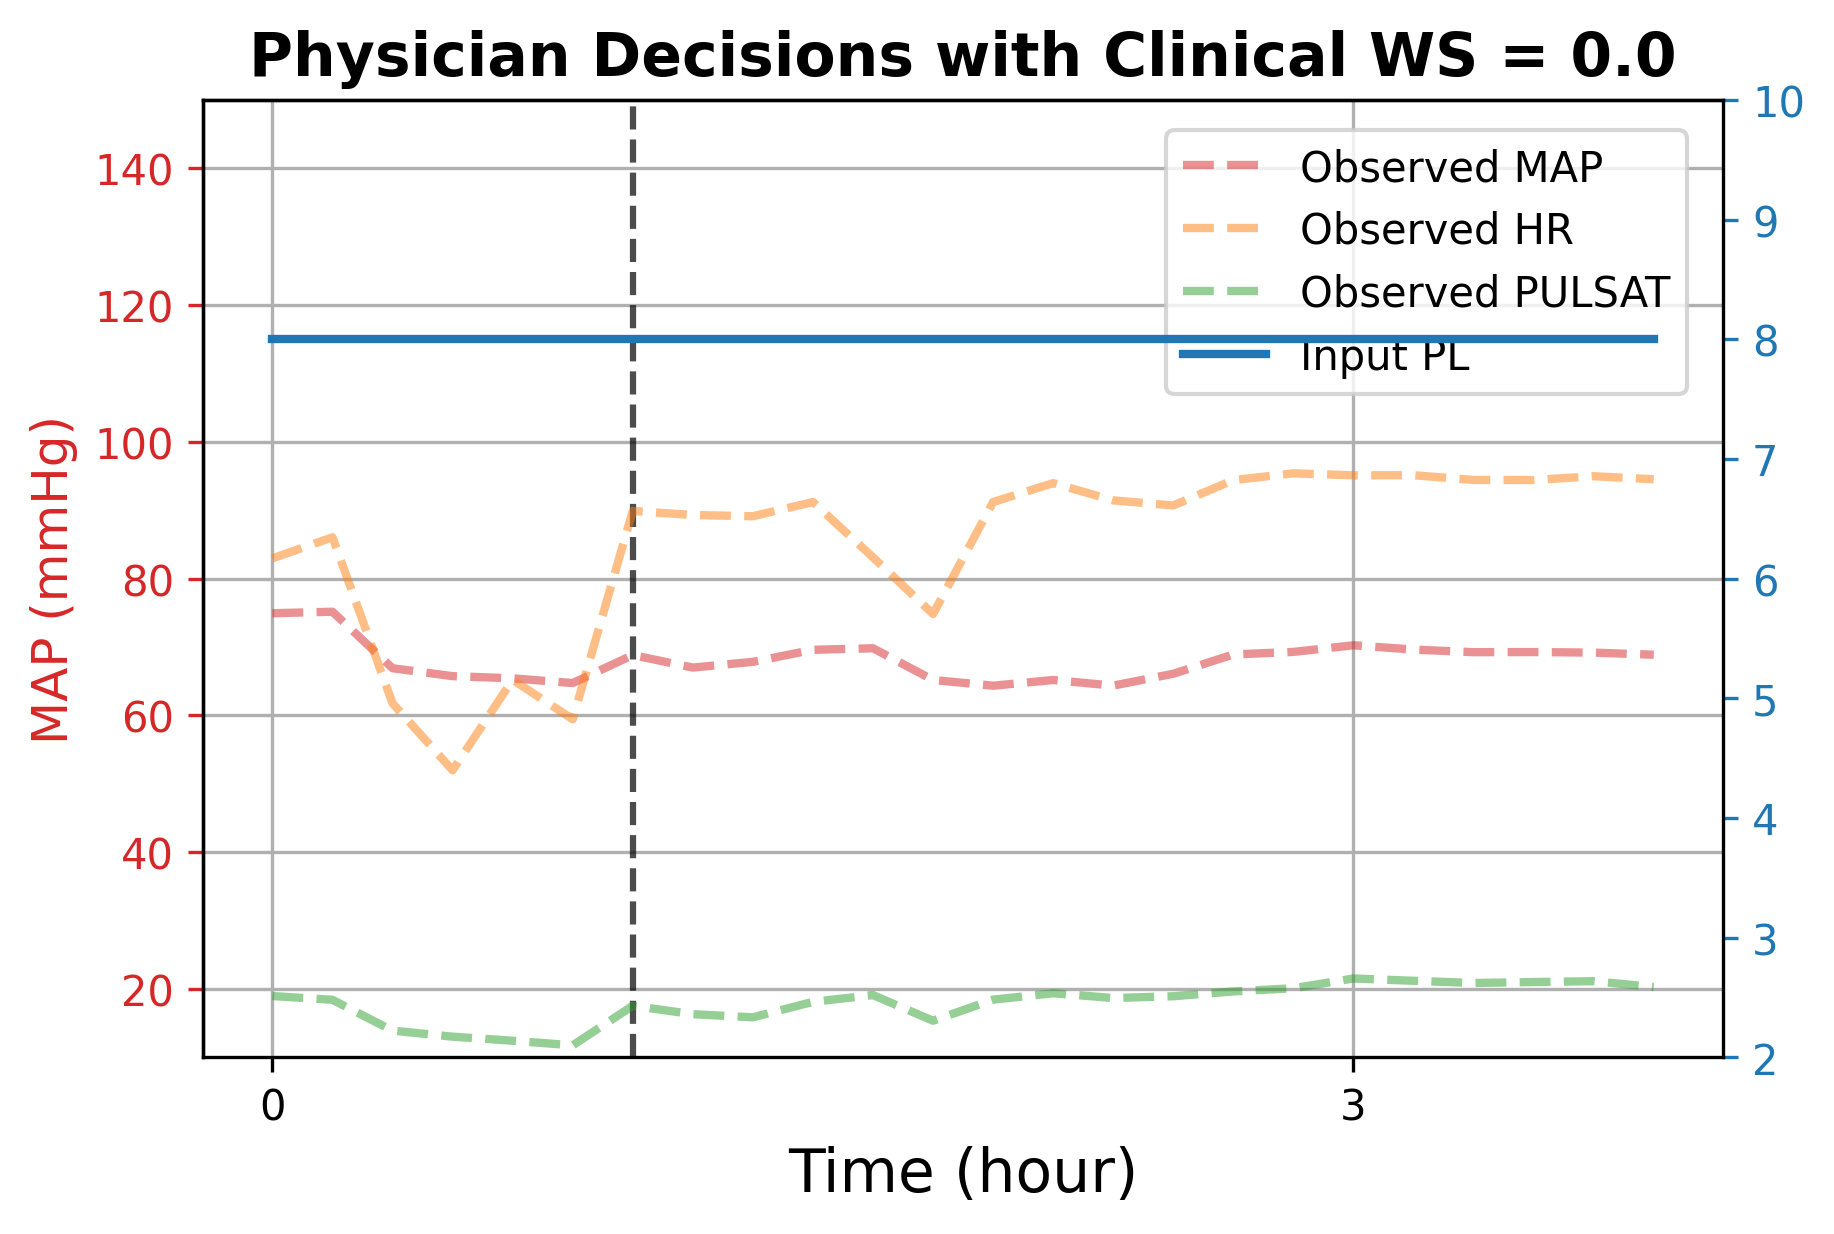

WS MERGED 0.0 Unstable hours merged 100.0
Unstable hours threshold 100.0 Unstable hours gradient 100.0


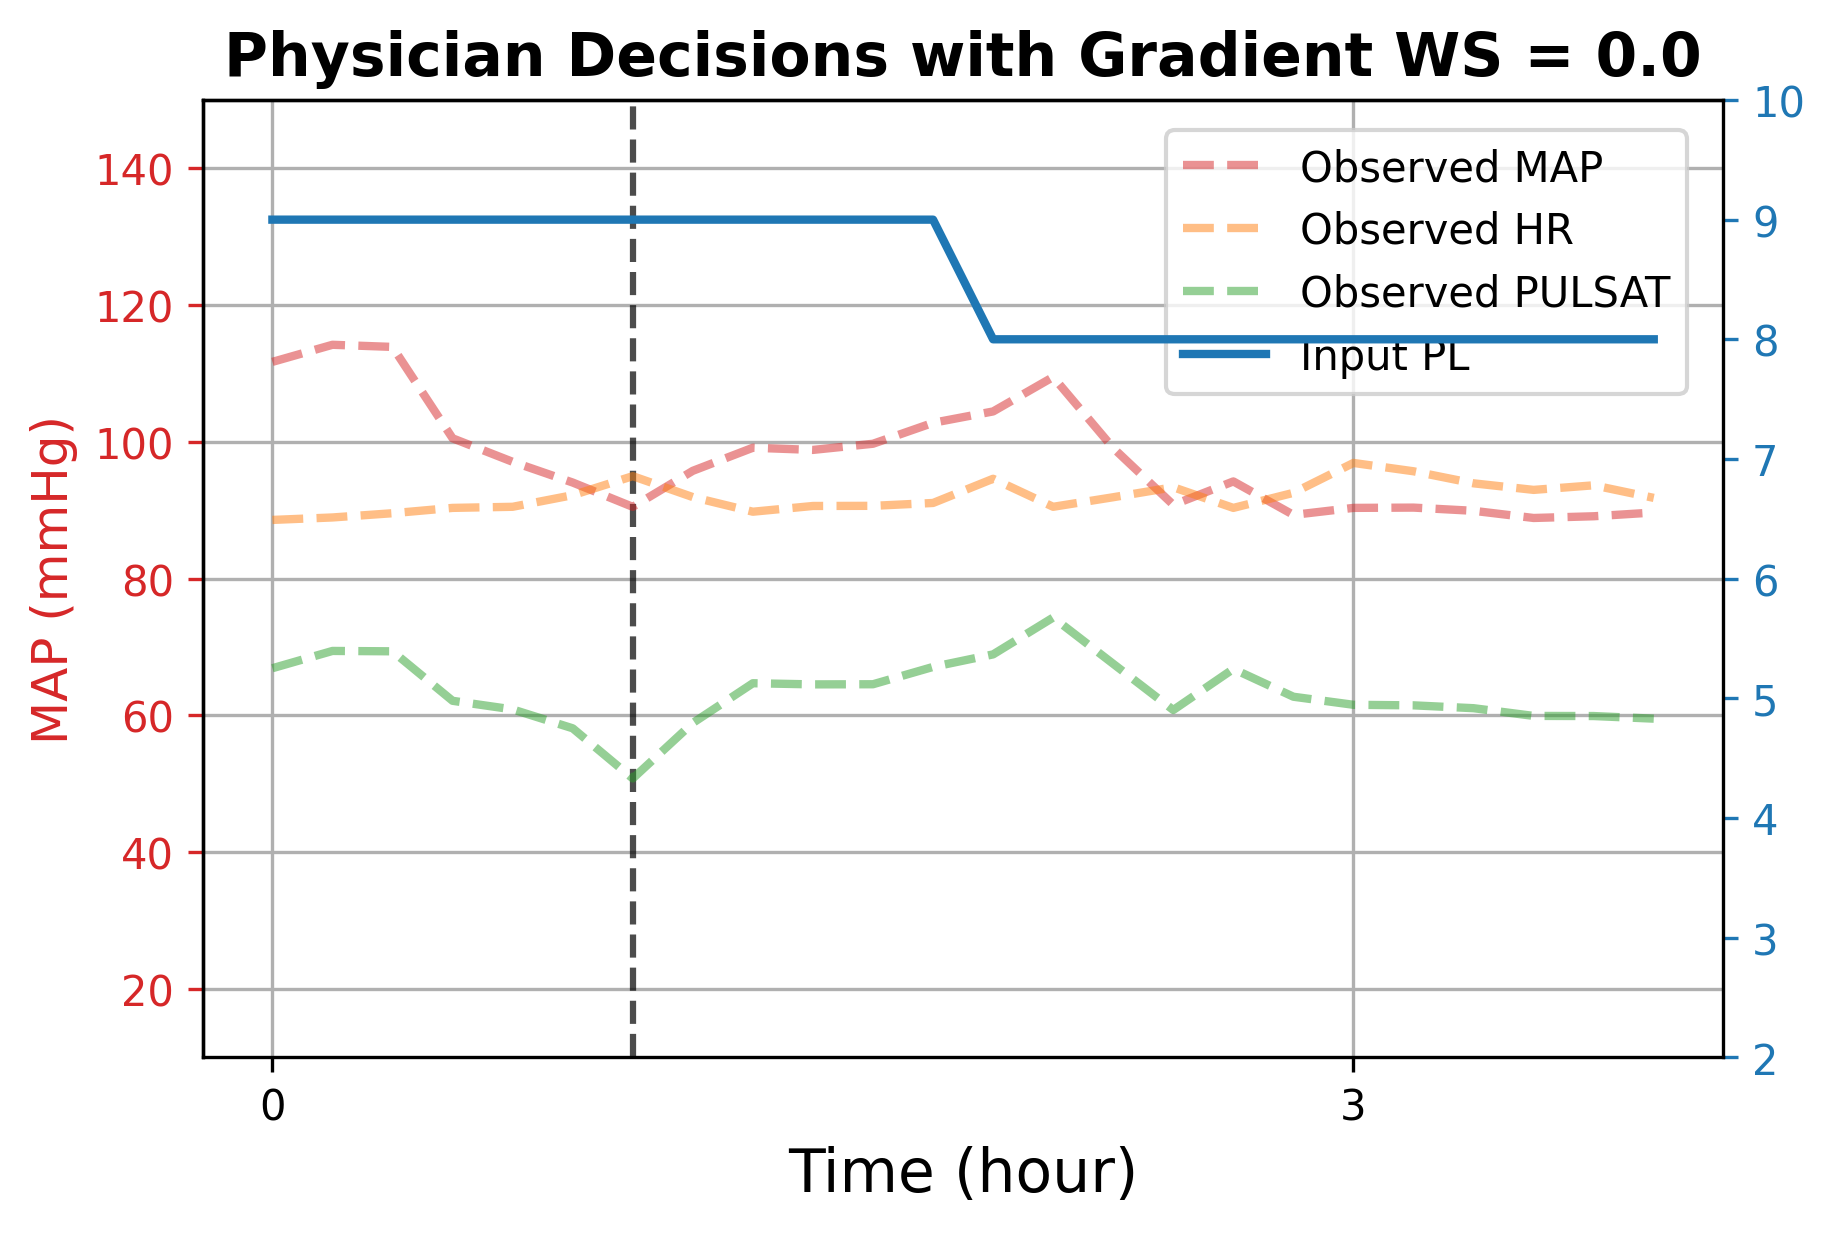

WS MERGED 0.3333333333333333 Unstable hours merged 0.0
Unstable hours threshold 0.0 Unstable hours gradient 100.0


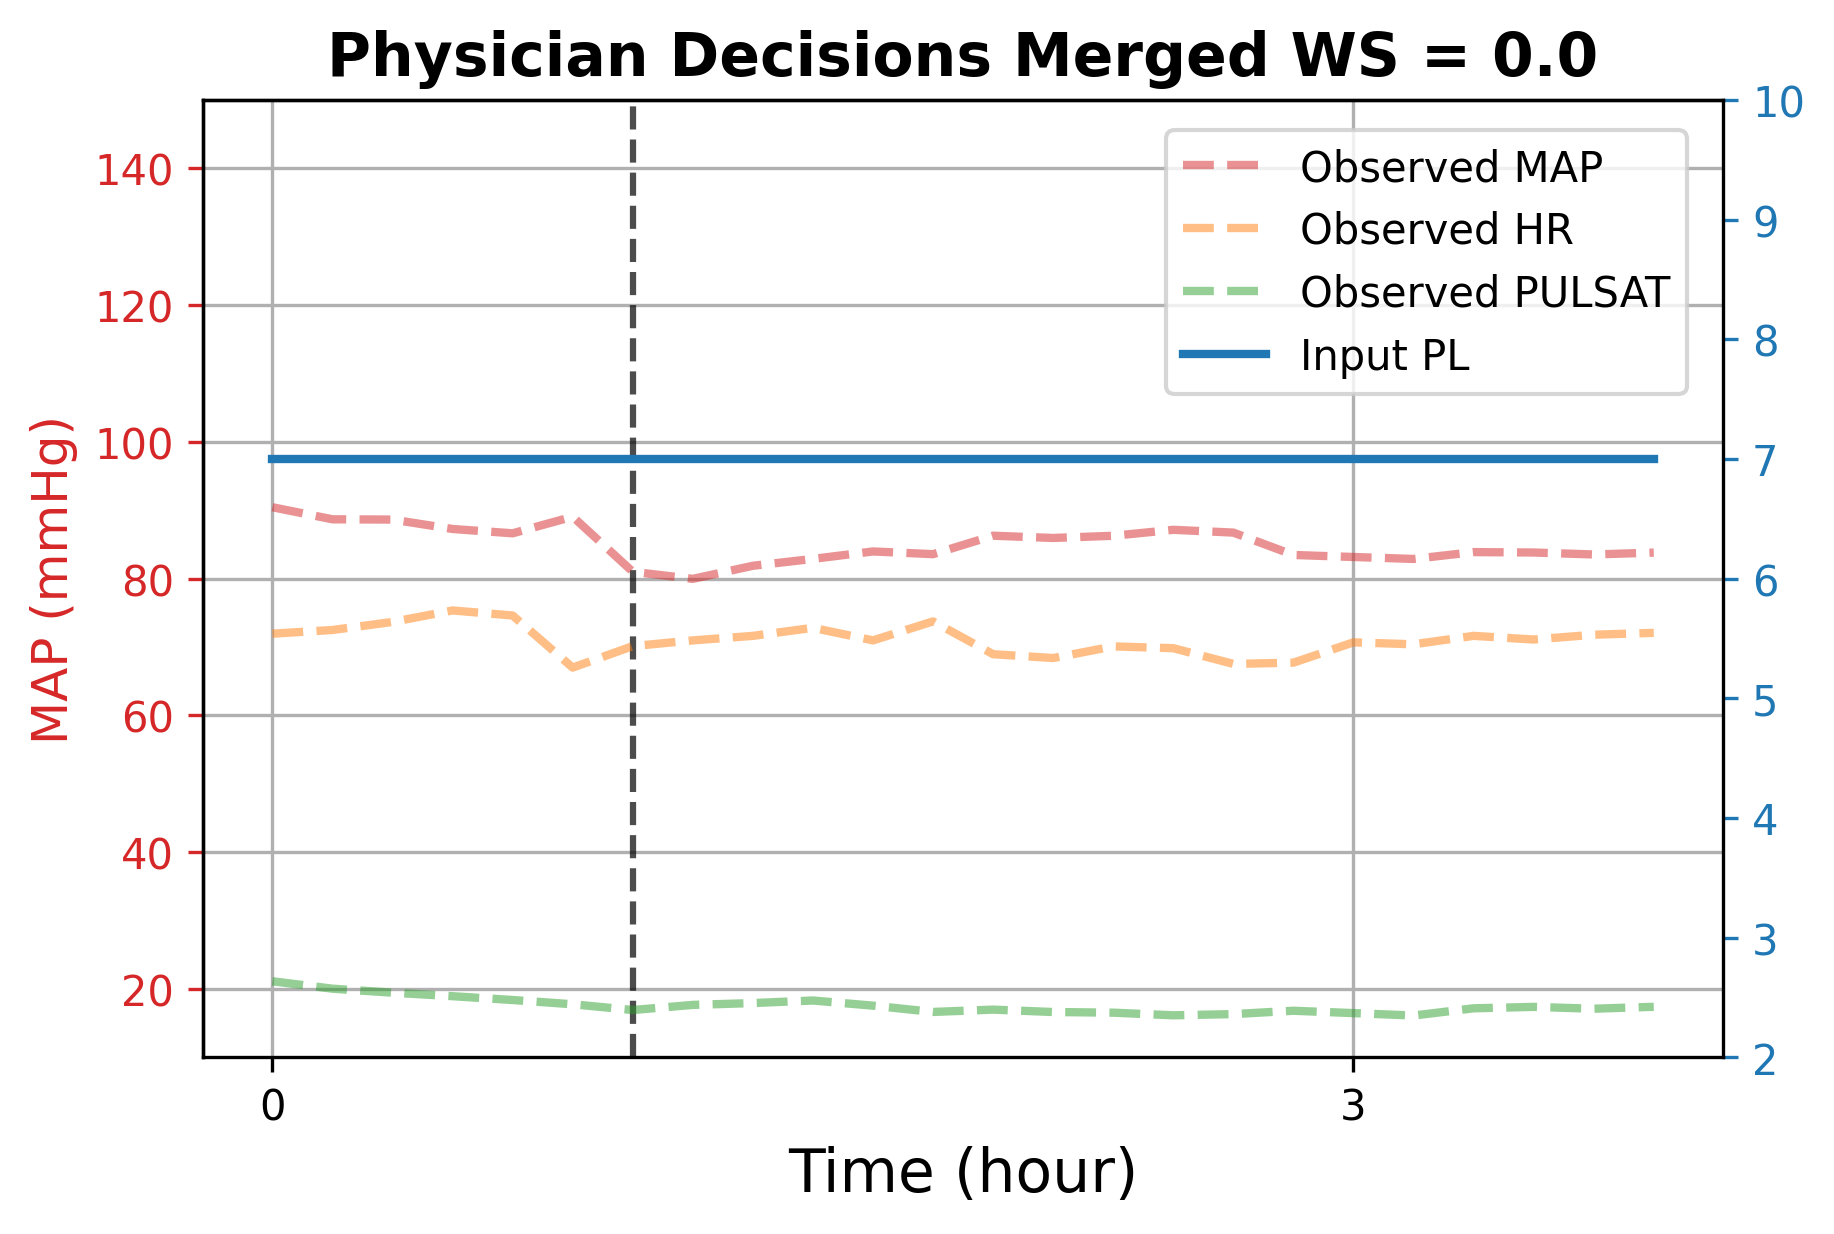

WS MERGED 0.0 Unstable hours merged 0.0
Unstable hours threshold 100.0 Unstable hours gradient 0.0
---------------------------------------
Evaluation over 1488 episodes: Return 0.307
ACP 0.7312
Aggregate AIR/ep: 0.52946
Unstable hours (%): 38.08243727598567
Unstable hours gradient (%): 47.759856630824395
Unstable hours merged (%): 19.780465949820716
Weaning score: 0.04480286738351254
Weaning score merged: 0.07190860215053761
Weaning score thr: 0.07011648745519716
Super metric: 0.58065
---------------------------------------


([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  4.0,
  4.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  7.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  4.0,
  0.0,
  3.0,
  0.0,
  0.0,
  0.0,
  0.0,
  7.0,
  0.0,
  4.0,
  3.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  3.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  5.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  7.0,
  0.0,
  0.0,
  5.0,
  0.0,
  3.0,
  3.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  5.0,
  0.0,
  0.0,
  0.0,
  5.0,
  0.0,
  0.0,
  4.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [63]:
dt_based_evaluation(sliced_state_episodic3, sliced_next_state_episodic3, episode_len3, eval_episodes3)

In [66]:
dt_based_evaluation(sliced_state_episodic12, sliced_next_state_episodic12, episode_len12, eval_episodes12)

<module 'noisy_mujoco.abiomed_env.config' from '/home/ubuntu/noisy_mujoco/abiomed_env/config.py'>
time series transformer device cuda:1
Using device: cuda:1
Model loaded from /abiomed/downsampled/models/10min_1hr_all_data_model.pth
loaded datasets with length 
 train:  12051 
 val:  1938 
 test:  3876
Data loaded from /abiomed/downsampled/10min_1hr_all_data.pkl
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/ubuntu/noisy_mujoco/abiomed_env/model.py:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allow

---------------------------------------
Evaluation over 372 episodes: Return 1.228
ACP 4.0215
Aggregate AIR/ep: 0.31774
Unstable hours (%): 38.08243727598565
Unstable hours gradient (%): 47.75985663082433
Unstable hours merged (%): 19.780465949820776
Weaning score: 0.04867259383388416
Weaning score merged: 0.071035140188366
Weaning score thr: 0.09312101429036916
Super metric: 3.15591
---------------------------------------


([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  15.0,
  7.0,
  0.0,
  0.0,
  0.0,
  7.0,
  0.0,
  20.0,
  4.0,
  0.0,
  3.0,
  0.0,
  0.0,
  5.0,
  0.0,
  7.0,
  11.0,
  6.0,
  0.0,
  5.0,
  5.0,
  4.0,
  6.0,
  0.0,
  6.0,
  3.0,
  0.0,
  0.0,
  6.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  5.0,
  0.0,
  6.0,
  3.0,
  0.0,
  7.0,
  4.0,
  0.0,
  0.0,
  0.0,
  10.0,
  10.0,
  4.0,
  5.0,
  6.0,
  0.0,
  5.0,
  0.0,
  0.0,
  4.0,
  5.0,
  5.0,
  8.0,
  6.0,
  6.0,
  0.0,
  0.0,
  6.0,
  0.0,
  3.0,
  5.0,
  0.0,
  0.0,
  0.0,
  0.0,
  7.0,
  0.0,
  4.0,
  8.0,
  0.0,
  4.0,
  0.0,
  0.0,
  12.0,
  0.0,
  5.0,
  0.0,
  5.0,
  7.0,
  0.0,
  3.0,
  0.0,
  10.0,
  0.0,
  0.0,
  6.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  6.0,
  19.0,
  10.0,
  0.0,
  6.0,
  0.0,
  0.0,
  5.0,
  3.0,
  0.0,
  7.0,
  7.0,
  11.0,
  6.0,
  4.0,
  7.0,
  0.0,
  4.0,
  0.0,
  0.0,
  5.0,
  11.0,
  0.0,
  0.0,
  10.0,
  13.0,
  0.0,
  3.0,
  0.0,
  0.0,
  7.0,


In [67]:
dt_based_evaluation(sliced_state_episodic24, sliced_next_state_episodic24, episode_len24, eval_episodes24)

<module 'noisy_mujoco.abiomed_env.config' from '/home/ubuntu/noisy_mujoco/abiomed_env/config.py'>
time series transformer device cuda:1
Using device: cuda:1
Model loaded from /abiomed/downsampled/models/10min_1hr_all_data_model.pth


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/ubuntu/noisy_mujoco/abiomed_env/model.py:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allow

loaded datasets with length 
 train:  12051 
 val:  1938 
 test:  3876
Data loaded from /abiomed/downsampled/10min_1hr_all_data.pkl
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617


/tmp/ipykernel_282273/3358723293.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = eval_env.world_model.step(torch.tensor(state).unsqueeze(0), int(action1)).squeeze(0)


---------------------------------------
Evaluation over 186 episodes: Return 2.457
ACP 8.4247
Aggregate AIR/ep: 0.22447
Unstable hours (%): 38.08243727598566
Unstable hours gradient (%): 47.75985663082436
Unstable hours merged (%): 19.780465949820794
Weaning score: 0.051874742028954604
Weaning score merged: 0.07142023428733855
Weaning score thr: 0.09067888844274655
Super metric: 6.58602
---------------------------------------


([0.0,
  7.0,
  0.0,
  0.0,
  0.0,
  15.0,
  7.0,
  0.0,
  7.0,
  24.0,
  3.0,
  0.0,
  5.0,
  18.0,
  6.0,
  10.0,
  13.0,
  6.0,
  3.0,
  6.0,
  0.0,
  0.0,
  0.0,
  5.0,
  9.0,
  7.0,
  4.0,
  0.0,
  20.0,
  9.0,
  6.0,
  5.0,
  4.0,
  10.0,
  14.0,
  6.0,
  6.0,
  3.0,
  5.0,
  0.0,
  7.0,
  4.0,
  8.0,
  4.0,
  12.0,
  5.0,
  5.0,
  7.0,
  3.0,
  10.0,
  6.0,
  0.0,
  0.0,
  0.0,
  0.0,
  25.0,
  10.0,
  6.0,
  5.0,
  3.0,
  14.0,
  17.0,
  11.0,
  4.0,
  0.0,
  16.0,
  0.0,
  23.0,
  3.0,
  0.0,
  12.0,
  6.0,
  6.0,
  7.0,
  9.0,
  0.0,
  3.0,
  0.0,
  0.0,
  0.0,
  3.0,
  0.0,
  7.0,
  4.0,
  7.0,
  0.0,
  4.0,
  3.0,
  12.0,
  6.0,
  0.0,
  0.0,
  5.0,
  6.0,
  4.0,
  5.0,
  12.0,
  7.0,
  0.0,
  9.0,
  5.0,
  0.0,
  12.0,
  0.0,
  8.0,
  3.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  16.0,
  0.0,
  7.0,
  0.0,
  0.0,
  3.0,
  6.0,
  3.0,
  10.0,
  0.0,
  4.0,
  3.0,
  0.0,
  11.0,
  18.0,
  15.0,
  27.0,
  13.0,
  26.0,
  28.0,
  24.0,
  33.0,
  36.0,
  45.0,
  35.0,
  35.0,
  56.

In [225]:
#calculate the p-values for different thresholds
from scipy import stats
from scipy.stats import mannwhitneyu

def calculate_p_values(slope_list, s_vital= "MAP", thresholds=np.arange(0.6, 1.5, 0.01)):
    np_slope = np.array(slope_list).reshape(-1,3)
    p_vals = []
    dict_num = {"MAP":0, "HR":1, "PULSAT":2}
    for threshold in thresholds:
       
        stable = np_slope[np.abs(np_slope[:, dict_num[s_vital]]) < threshold, dict_num[s_vital]]
        unstable = np_slope[np.abs(np_slope[:, dict_num[s_vital]]) >= threshold, dict_num[s_vital]]
        if s_vital == "MAP":
            t_stat, p_value = stats.ttest_ind(stable, unstable, equal_var=False)
        else:
            t_stat, p_value = stats.ttest_ind(stable, unstable, equal_var=True)
        p_vals.append([threshold, p_value]) 
        # print(f"{vital} - t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}, threshold: {threshold}" ) if vital == s_vital else None

    # Find the threshold value closest to 0.05 from p_vals
    p_vals = np.array(p_vals)
    idx = np.argmin(np.abs(p_vals[:, 1] - 0.05))
    #sort p_vals based on the distance from 0.05 in ascending order and pick the top 5 closest values
    
    if s_vital == "PULSAT":
        distances = np.abs(p_vals[:, 1] - 0.05)
        sorted_indices = np.argsort(distances)
        top_20 = p_vals[sorted_indices[:40]]
        top_20 = top_20[np.argsort(top_20[:, 0])]
        print("Top 20 closest thresholds to p-value 0.05 for PULSAT:",top_20)
        thr_val, p_val = top_20[0]
    else:
        thr_val = p_vals[idx][0]
        p_val = p_vals[idx][1]
    
    print(f"Threshold at p-value 0.05: {thr_val:.2f} with p-value {p_val:.4f}")
    p_vals = np.array(p_vals).reshape(-1,2)
    plt.figure(figsize=(8, 5))
    plt.plot(p_vals[:,0], p_vals[:,1], marker='.')
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
    plt.axvline(x=thr_val, color='g', linestyle='--', label=f'Threshold at 0.05 = {thr_val:.2f}')

    plt.xlabel('Threshold')

    plt.ylabel('p-value')
    plt.title(f'Threshold vs p-value for {s_vital} Gradients')
    # plt.yscale('log')  # Use logarithmic scale for better visibility
    plt.legend()
    plt.grid(True)
    plt.show()



Threshold at p-value 0.05: 1.36 with p-value 0.0495


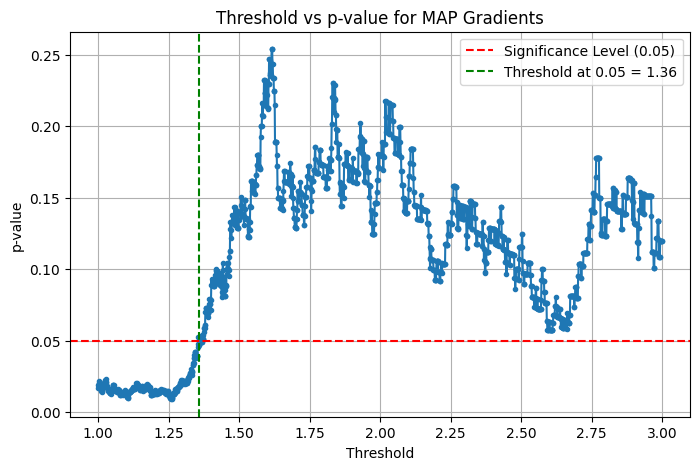

In [213]:
calculate_p_values(slope_list6, s_vital = "MAP", thresholds = np.arange(1, 3, 0.001))

In [188]:
print(np.array(slope_list6)[:, 0].mean(), np.array(slope_list6)[:, 0].std())
print(np.array(slope_list6)[:, 1].mean(), np.array(slope_list6)[:, 1].std())
print(np.array(slope_list6)[:, 2].mean(), np.array(slope_list6)[:, 2].std())


0.020755256406477702 1.2575816291133495
-0.13671354634665425 1.4011524588318944
-0.06680637720726296 1.1809066295180692


Threshold at p-value 0.05: 2.15 with p-value 0.0494


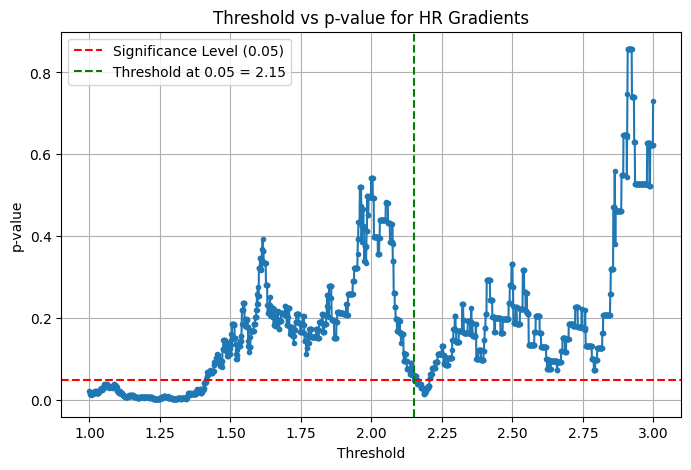

In [194]:
calculate_p_values(slope_list6, s_vital = "HR", thresholds = np.arange(1, 3, 0.001))

Top 20 closest thresholds to p-value 0.05 for PULSAT: [[1.95       0.09084228]
 [1.96       0.0568928 ]
 [4.3        0.05040368]
 [4.31       0.05040368]
 [4.35       0.04498599]
 [4.36       0.04498599]
 [4.37       0.04498599]
 [4.38       0.04498599]
 [4.39       0.04498599]
 [4.4        0.04498599]
 [4.41       0.04498599]
 [4.42       0.03918873]
 [4.43       0.03918873]
 [4.44       0.03918873]
 [4.45       0.03918873]
 [4.46       0.03918873]
 [4.5        0.03311272]
 [4.51       0.03311272]
 [4.52       0.03311272]
 [4.53       0.03311272]
 [4.54       0.02783586]
 [4.55       0.02783586]
 [4.56       0.02783586]
 [4.57       0.02783586]
 [4.58       0.02783586]
 [4.59       0.02783586]
 [4.6        0.02783586]
 [4.61       0.02783586]
 [4.62       0.02278455]
 [4.63       0.02278455]
 [4.64       0.02278455]
 [4.65       0.02278455]
 [4.66       0.02278455]
 [4.67       0.02278455]
 [4.68       0.02278455]
 [4.69       0.02278455]
 [4.74       0.01846663]
 [4.75       0.018466

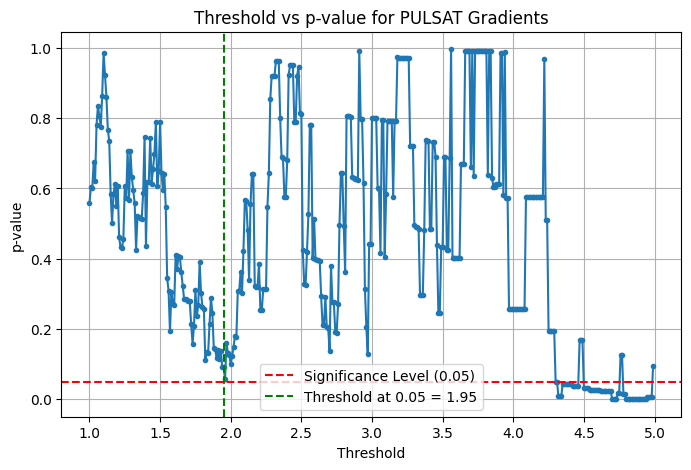

In [226]:
calculate_p_values(slope_list6, s_vital = "PULSAT", thresholds = np.arange(1, 5, 0.01))

In [ ]:
np_slope = np.array(slope_list6).reshape(-1,3)
plt.hist(np_slope[:,0], bins=100)
plt.title('Histogram of MAP Gradients of Expert DT')
plt.axvline(x=-1.36, color='red', linestyle='--', label='-Threshold = -1.36')
plt.axvline(x=1.36, color='red', linestyle='--', label='+Threshold = +1.36')
plt.axvspan(-1.36, np.min(np_slope[:, 0]), color='gray', alpha=0.3, label='Unstable')
plt.axvspan(np.max(np_slope[:, 0]), 1.36, color='gray', alpha=0.3)
plt.xticks(np.arange(-8, 9, 1))
plt.xlim(-8, 8)
plt.legend()
plt.show()

plt.hist(np_slope[:,1], bins=100)
plt.axvline(x=-2.16,color='red', linestyle='--', label='-Threshold = -2.16')
plt.axvline(x=2.16, color='red', linestyle='--', label='+Threshold = +2.16')
plt.axvspan(-2.16, np.min(np_slope[:, 1]), color='gray', alpha=0.3, label='Unstable')
plt.axvspan(np.max(np_slope[:, 1]), 2.16,  color='gray', alpha=0.3)
plt.title('Histogram of HR Gradients of Expert DT')
plt.xticks(np.arange(-8, 9, 1))
plt.xlim(-8, 8)
plt.legend()
plt.show()

plt.hist(np_slope[:,2], bins=100)
plt.axvline(x=-1.95, color='red', linestyle='--', label='-Threshold = -1.95')
plt.axvline(x=1.95, color='red', linestyle='--', label='+Threshold = +1.95')
plt.axvspan(-1.95, np.min(np_slope[:, 2]), color='gray', alpha=0.3, label='Unstable')
plt.axvspan(np.max(np_slope[:, 2]), 1.95, color='gray', alpha=0.3)
plt.title('Histogram of PULSAT Gradients of Expert DT')
plt.xticks(np.arange(-9, 10, 1))
plt.xlim(-8, 8)
plt.legend()
plt.show()

In [45]:
min(rwd_list), max(rwd_list), np.mean(rwd_list), np.median(rwd_list)

(-12.0, 3.835618496675557, 0.6141968336263548, 1.8609994319924403)

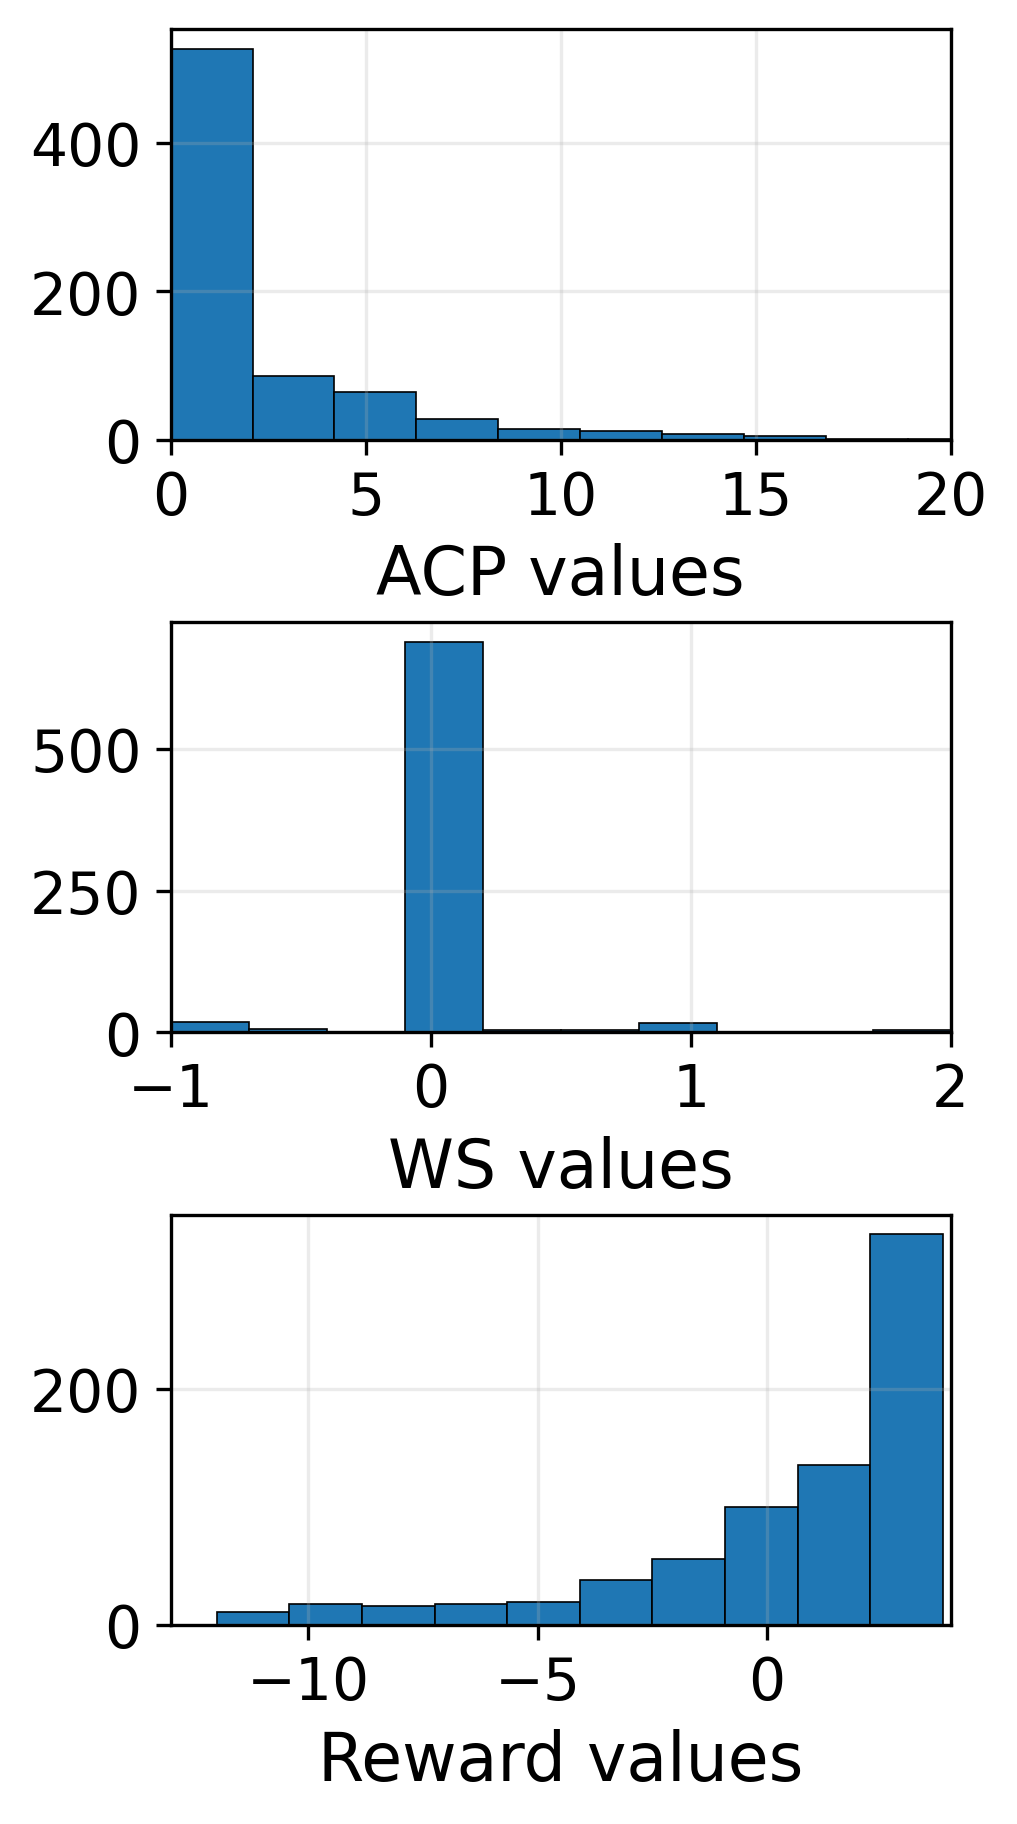

In [40]:
plot_hist(acp_list, ws_list, rwd_list, title="Expert")

In [38]:
len(ws_list)

744

(array([ 75.,  63.,  56.,  90., 121., 106., 104.,  59.,  26.,  44.]),
 array([ -5.5445483 ,  41.12208575,  87.7887198 , 134.45535386,
        181.12198791, 227.78862196, 274.45525602, 321.12189007,
        367.78852413, 414.45515818, 461.12179223]),
 <BarContainer object of 10 artists>)

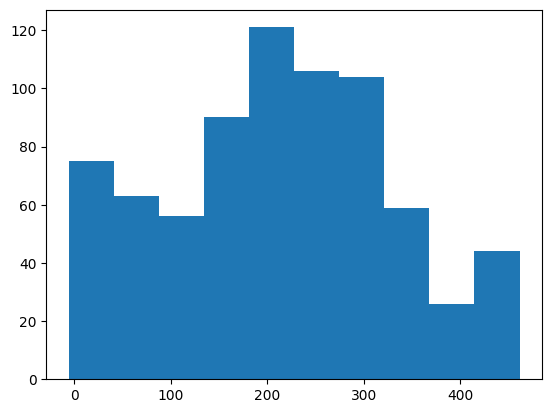

In [31]:
plt.hist(rwd_list)

# Synthetic Dataset

In [11]:
# SYN_DATA_PATH = "/abiomed/offline_datasets/SAC_exp_5000eps_stochastic.npz"
SYN_DATA_PATH = "/abiomed/offline_datasets/SAC_exp_5000eps_stochastic_noise0.80_scale0.20.npz"
eval_env = AbiomedRLEnvFactory.create_env(
									model_name="10min_1hr_all_data",
									model_path=None,
									data_path=None,
									max_steps=6,
									action_space_type="continuous",
									reward_type="smooth",
									normalize_rewards=True,
                                    noise_rate= 0.8,
                                    noise_scale = 0.2,
									seed=42,
									device = f"cuda:1" if torch.cuda.is_available() else "cpu",
									)

dataset = np.load(SYN_DATA_PATH)
dataset = {k: dataset[k] for k in dataset.files}

dataset['observations'] =  dataset['observations'][::4]
dataset['next_observations'] = dataset['next_observations'][::4]
dataset['actions'] = dataset['actions'][::4]
dataset['rewards'] = dataset['rewards'][::4]



# dataset['actions'] = np.asarray(eval_env.world_model.normalize_pl(torch.Tensor(dataset['actions']))).reshape(-1,1)

<module 'noisy_mujoco.abiomed_env.config' from '/home/ubuntu/noisy_mujoco/abiomed_env/config.py'>
time series transformer device cuda:1
Using device: cuda:1
Model loaded from /abiomed/downsampled/models/10min_1hr_all_data_model.pth
loaded datasets with length 
 train:  12051 
 val:  1938 
 test:  3876
Data loaded from /abiomed/downsampled/10min_1hr_all_data.pkl
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617
Noise rate: 0.8, Noise scale: 0.2
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617


In [6]:
next_states = dataset['next_observations'].copy().reshape(-1,6,6,12)
states = dataset['observations'].copy().reshape(-1,6,6,12)
action_all = dataset['actions'].copy().reshape(-1,6,1,1)
col = [0,1,2,3,4,5,6,7,8,9,10,12]
eval_episodes = states.shape[0]
episode_len = states.shape[1]
avg_reward = 0.0
avg_acp = 0.0


In [7]:

# ---- aggregated metrics over episodes ----
total_map_air_sum = 0.0
total_hr_air_sum = 0.0
total_pulsatility_air_sum = 0.0
total_aggregate_air_sum = 0.0
total_unstable_percentage_sum = 0.0
total_super_sum = 0.0
wean_score_sum = 0.0

for k in range(eval_episodes):
    ep_states = []           # store normalized states per step (like in _evaluate)
    actions = []
    for t in range(episode_len):
        action1 = action_all[k, t, :, -1]
        # action1 = np.array(np.bincount(action.astype(int)).argmax())
        state = states[k, t, :, :]
        #normalize the state
        # state = (torch.tensor(state) - eval_env.world_model.mean[col]) / eval_env.world_model.std[col]

        with torch.no_grad():
            next_state = eval_env.world_model.step(torch.tensor(state).unsqueeze(0), int(action1)).squeeze(0)
        
        reward = eval_env._compute_reward(next_state)
        avg_reward += reward.item()  # accumulate raw reward

        ep_states.append(state)   # store the *current* obs like _evaluate
        actions.append(int(action1))  # store the *current* action like _evaluate

    
    ep_states_np = np.asarray(ep_states, dtype=np.float32) #normalized
    action_np = np.asarray(actions, dtype=np.int32) #unnormalized


    wm = getattr(eval_env, 'world_model', None)
    if wm is None:
        wm = eval_env.world_model  # fallback to global `env` if that's how you access it

    # AIR metrics
    # total_map_air_sum          += compute_map_physician_air(wm, ep_states_np, eval_env.episode_actions)
    # total_hr_air_sum           += compute_hr_physician_air(wm, ep_states_np, eval_env.episode_actions)
    # total_pulsatility_air_sum  += compute_pulsatility_physician_air(wm, ep_states_np, eval_env.episode_actions)
    avg_acp += compute_acp_cost_model(wm,action_np,ep_states_np)
    total_aggregate_air_sum    += aggregate_air_model(wm, ep_states_np, action_np)
    total_super_sum            += super_metric(wm, ep_states_np, action_np)
    wean_score_sum             += weaning_score_model(wm, ep_states_np, action_np)
    # total_unstable_percentage_sum += unstable_percentage(wm, ep_states_np)   

# ---- episode averages ----
avg_reward /= eval_episodes
acp_mean = avg_acp / eval_episodes

map_air_mean          = total_map_air_sum / eval_episodes
hr_air_mean           = total_hr_air_sum / eval_episodes
puls_air_mean         = total_pulsatility_air_sum / eval_episodes
aggregate_air_mean    = total_aggregate_air_sum / eval_episodes
unstable_hours_mean   = total_unstable_percentage_sum / eval_episodes
weaning_score_mean    = wean_score_sum / eval_episodes
super_mean            = total_super_sum / eval_episodes

print("---------------------------------------")
print(f"Evaluation over {eval_episodes} episodes: "
        f"Return {avg_reward:.3f}")
print(f"ACP {acp_mean:.4f}")
# print(f"MAP AIR/ep: {map_air_mean:.5f} | HR AIR/ep: {hr_air_mean:.5f} "
#         f"| Pulsatility AIR/ep: {puls_air_mean:.5f}")
print(f"Aggregate AIR/ep: {aggregate_air_mean:.5f}")
print(f"Unstable hours (%): {unstable_hours_mean}")
print(f"Weaning score: {weaning_score_mean}")
print(f"Super metric: {super_mean:.5f}")
print("---------------------------------------")

KeyboardInterrupt: 

In [12]:
#just 100 eval episodes for reward
unnorm_state = eval_env.world_model.unnorm_output(torch.tensor(dataset['observations'].reshape(-1,6,12), dtype=torch.float32)).reshape(-1,6,6,12)
unnorm_next_state = eval_env.world_model.unnorm_output(torch.tensor(dataset['next_observations'].reshape(-1,6,12), dtype=torch.float32)).reshape(-1,6,6,12)



all_normalized_rewards = []
total_map_air_sum          = 0
total_hr_air_sum           = 0
total_pulsatility_air_sum  = 0
total_aggregate_air_sum    = 0
total_super_sum            = 0
avg_acp = 0
wean_score_sum = 0

for episode_idx in range(eval_episodes):
    episode_states = []
    episode_actions = []
    total_normalized_reward = 0
    for state_idx in range(episode_len):
        
        state = unnorm_state[episode_idx, state_idx, :, :]
        next_state = unnorm_next_state[episode_idx, state_idx, :, :]
        action = action_all[episode_idx, state_idx, :, :].reshape(-1)

        reward = compute_reward_smooth(next_state)
        norm_reward = (reward + 1.7018) / 2.6621
        total_normalized_reward += np.clip(norm_reward, -2.0, None) 

        episode_states.append(state.numpy())
        episode_actions.append(action)
    episode_states_np = np.asarray(episode_states)
    all_normalized_rewards.append(total_normalized_reward)
    avg_acp += compute_acp_cost(np.asarray(episode_actions).reshape(-1), episode_states_np)
    # total_map_air_sum          += compute_map_physician_air(episode_states, episode_actions)
    # total_hr_air_sum           += compute_hr_physician_air( episode_states,episode_actions)
    # total_pulsatility_air_sum  += compute_pulsatility_physician_air( episode_states, episode_actions)
    total_aggregate_air_sum    += aggregate_air_physician(episode_states_np, np.asarray(episode_actions).reshape(-1))
    wean_score_sum             += weaning_score_physician(episode_states_np, np.asarray(episode_actions).reshape(-1))

    # total_super_sum            += super_metric(episode_states, episode_actions)
mean_normalized_reward = np.mean(all_normalized_rewards)
print(f"Mean normalized reward per episode: {mean_normalized_reward:.4f}")
avg_acp /= eval_episodes
print(f"Mean ACP per episode: {avg_acp:.4f}")

total_aggregate_air_sum /= eval_episodes
print(f"Mean Aggregate AIR per episode: {total_aggregate_air_sum:.4f}")
total_super_sum /= eval_episodes
print(f"Mean Super Metric per episode: {total_super_sum:.4f}")
total_weaning_score = wean_score_sum / eval_episodes
print(f"Mean Weaning Score per episode: {total_weaning_score:.4f}")

Mean normalized reward per episode: 1.4364
Mean ACP per episode: 9.2624
Mean Aggregate AIR per episode: 0.4279
Mean Super Metric per episode: 0.0000
Mean Weaning Score per episode: -0.1232
